In [2]:
import requests
import polars as pl
import numpy as np
from datetime import datetime
import pybaseball as pyb
from tqdm import tqdm
from pytz import timezone
import pandas as pd
import seaborn as sns
import re
from concurrent.futures import ThreadPoolExecutor, as_completed

In [3]:
# Import the MLB_Scrape class from the module
from api_scraper import MLB_Scrape

# Initialize the scraper
scraper = MLB_Scrape()

In [4]:
from matplotlib import font_manager
available_fonts = sorted([f.name for f in font_manager.fontManager.ttflist])
print(available_fonts)


['Arial', 'Arial', 'Arial', 'Arial', 'Arial', 'Bahnschrift', 'Calibri', 'Calibri', 'Calibri', 'Calibri', 'Calibri', 'Calibri', 'Cambria', 'Cambria', 'Cambria', 'Cambria', 'Candara', 'Candara', 'Candara', 'Candara', 'Candara', 'Candara', 'Comic Sans MS', 'Comic Sans MS', 'Comic Sans MS', 'Comic Sans MS', 'Consolas', 'Consolas', 'Consolas', 'Consolas', 'Constantia', 'Constantia', 'Constantia', 'Constantia', 'Corbel', 'Corbel', 'Corbel', 'Corbel', 'Corbel', 'Corbel', 'Courier New', 'Courier New', 'Courier New', 'Courier New', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans Display', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif Display', 'Ebrima', 'Ebrima', 'Franklin Gothic Medium', 'Franklin Gothic Medium', 'Gabriola', 'Gadugi', 'Gadugi', 'Georgia', 'Georgia', 'Georgia', 'Georgia', 'HoloLens MDL2 Assets', 'Impact', 'Ink Free', 'Javanese Text', 'Leelawad

In [5]:
# Define font properties for general text
font_properties = {'family': 'Arial', 'size': 12}

# Define font properties for titles
font_properties_titles = {'family': 'Arial', 'size': 20}

# Define font properties for axes labels
font_properties_axes = {'family': 'Arial', 'size': 16}

# Set the theme for seaborn plots
sns.set_theme(style='darkgrid', 
              palette='deep', 
              font='Arial', 
              font_scale=1.5, 
              color_codes=True, 
              rc=None)

# Import matplotlib
import matplotlib as mpl

# Set the resolution of the figures to 300 DPI
mpl.rcParams['figure.dpi'] = 300

In [6]:
mpl.rcParams['font.family'] = 'Arial'

In [10]:

import datasets
from datasets import load_dataset

## Download data from 2020 to 2023 seasons                                                       
dataset = load_dataset('nesticot/mlb_data', data_files=['mlb_pitch_data_2023.csv',
                                                        'mlb_pitch_data_2022.csv',
                                                        'mlb_pitch_data_2021.csv',
                                                        'mlb_pitch_data_2020.csv'])
dataset_train = dataset['train']

## Convert dataset into Pandas Dataframe
df = dataset_train.to_pandas().set_index(list(dataset_train.features.keys())[0]).reset_index(drop=True)

Generating train split: 160000 examples [00:03, 44314.99 examples/s]C:\Users\Jackson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\datasets\packaged_modules\csv\csv.py:190: DtypeWarning: Columns (15,16,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  for batch_idx, df in enumerate(csv_file_reader):
Generating train split: 260000 examples [00:05, 43967.12 examples/s]C:\Users\Jackson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\datasets\packaged_modules\csv\csv.py:190: DtypeWarning: Columns (15,16,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  for batch_idx, df in enumerate(csv_file_reader):
Generating train split: 310000 examples [00:06, 43930.21 examples/s]C:\Users\Jackson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-

In [11]:
# Add a season column to separate 2020 to 2022 data from 2023 data
df['season'] = df['game_date'].str[0:4].astype(int)

## Classify if an event is a Batted Ball Event 
df['bip'] = [1 if x > 0  else np.nan for x in df['launch_speed']]

## Define a 'Total Bases' column to define batted ball outcomes
conditions_tb = [(df['event_type']=='single'),
                 (df['event_type']=='double'),
                 (df['event_type']=='triple'),
                 (df['event_type']=='home_run')]

## Assign 'Total Bases' value to each condition
choices_tb = [1,
              2,
              3,
              4]

## Assign Total Base Value to batted ball events. 0 for all field outs
df['tb'] = np.select(conditions_tb, choices_tb, default=0)

## Define a 'wOBA' column to calculate wOBA for each event 
## We will use this later to compare to our xwOBA metric
conditions_woba = [(df['event_type']=='walk'),
                   (df['event_type']=='hit_by_pitch'),
                   (df['event_type']=='single'),
                   (df['event_type']=='double'),
                   (df['event_type']=='triple'),
                   (df['event_type']=='home_run')]

choices_woba =    [0.696,
                   0.726,
                   0.883,
                   1.244,
                   1.569,
                   2.004]

df['woba'] = np.select(conditions_woba, choices_woba, default=0)

## Filter out all non-batted ball events for training
df_bip = df[~df['bip'].isnull()].dropna(subset=['launch_speed','launch_angle','bip'])

## Train on 2020-22 Data and keep 2023 Data for analysis
df_bip_train = df_bip[~(df_bip['season'] == 2023)]
df_bip_2023 = df_bip[df_bip['season'] == 2023]
                 
## Filter out 2023 data for use later
df_2023 = df[df['season'] == 2023]

## Features for the model will be launch angle, launch speed
features = ['launch_angle','launch_speed']

## Target will be Total Bases

target = 'tb'

## Clean up training data
df_model_bip_train = df_bip_train.dropna(subset=features+[target])

In [12]:
## Import Machine learning packages and functions
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, r2_score

## Define feature data and target data as X and y
X = df_model_bip_train[features]
y = df_model_bip_train[target]

## Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Create a KNN classifier
k_value = 12
model = KNeighborsClassifier(n_neighbors=k_value)

## Train the model on the training data
model.fit(X_train, y_train)

## Make predictions on the testing data
y_pred = model.predict(X_test)

## Evaluate the performance of the model
classification_rep = classification_report(y_test, y_pred, zero_division=1)

## Print the results
print("\nClassification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.92      0.86     39112
           1       0.63      0.49      0.55     11933
           2       0.39      0.14      0.21      3760
           3       1.00      0.00      0.00       321
           4       0.71      0.66      0.68      2620

    accuracy                           0.76     57746
   macro avg       0.71      0.44      0.46     57746
weighted avg       0.74      0.76      0.74     57746



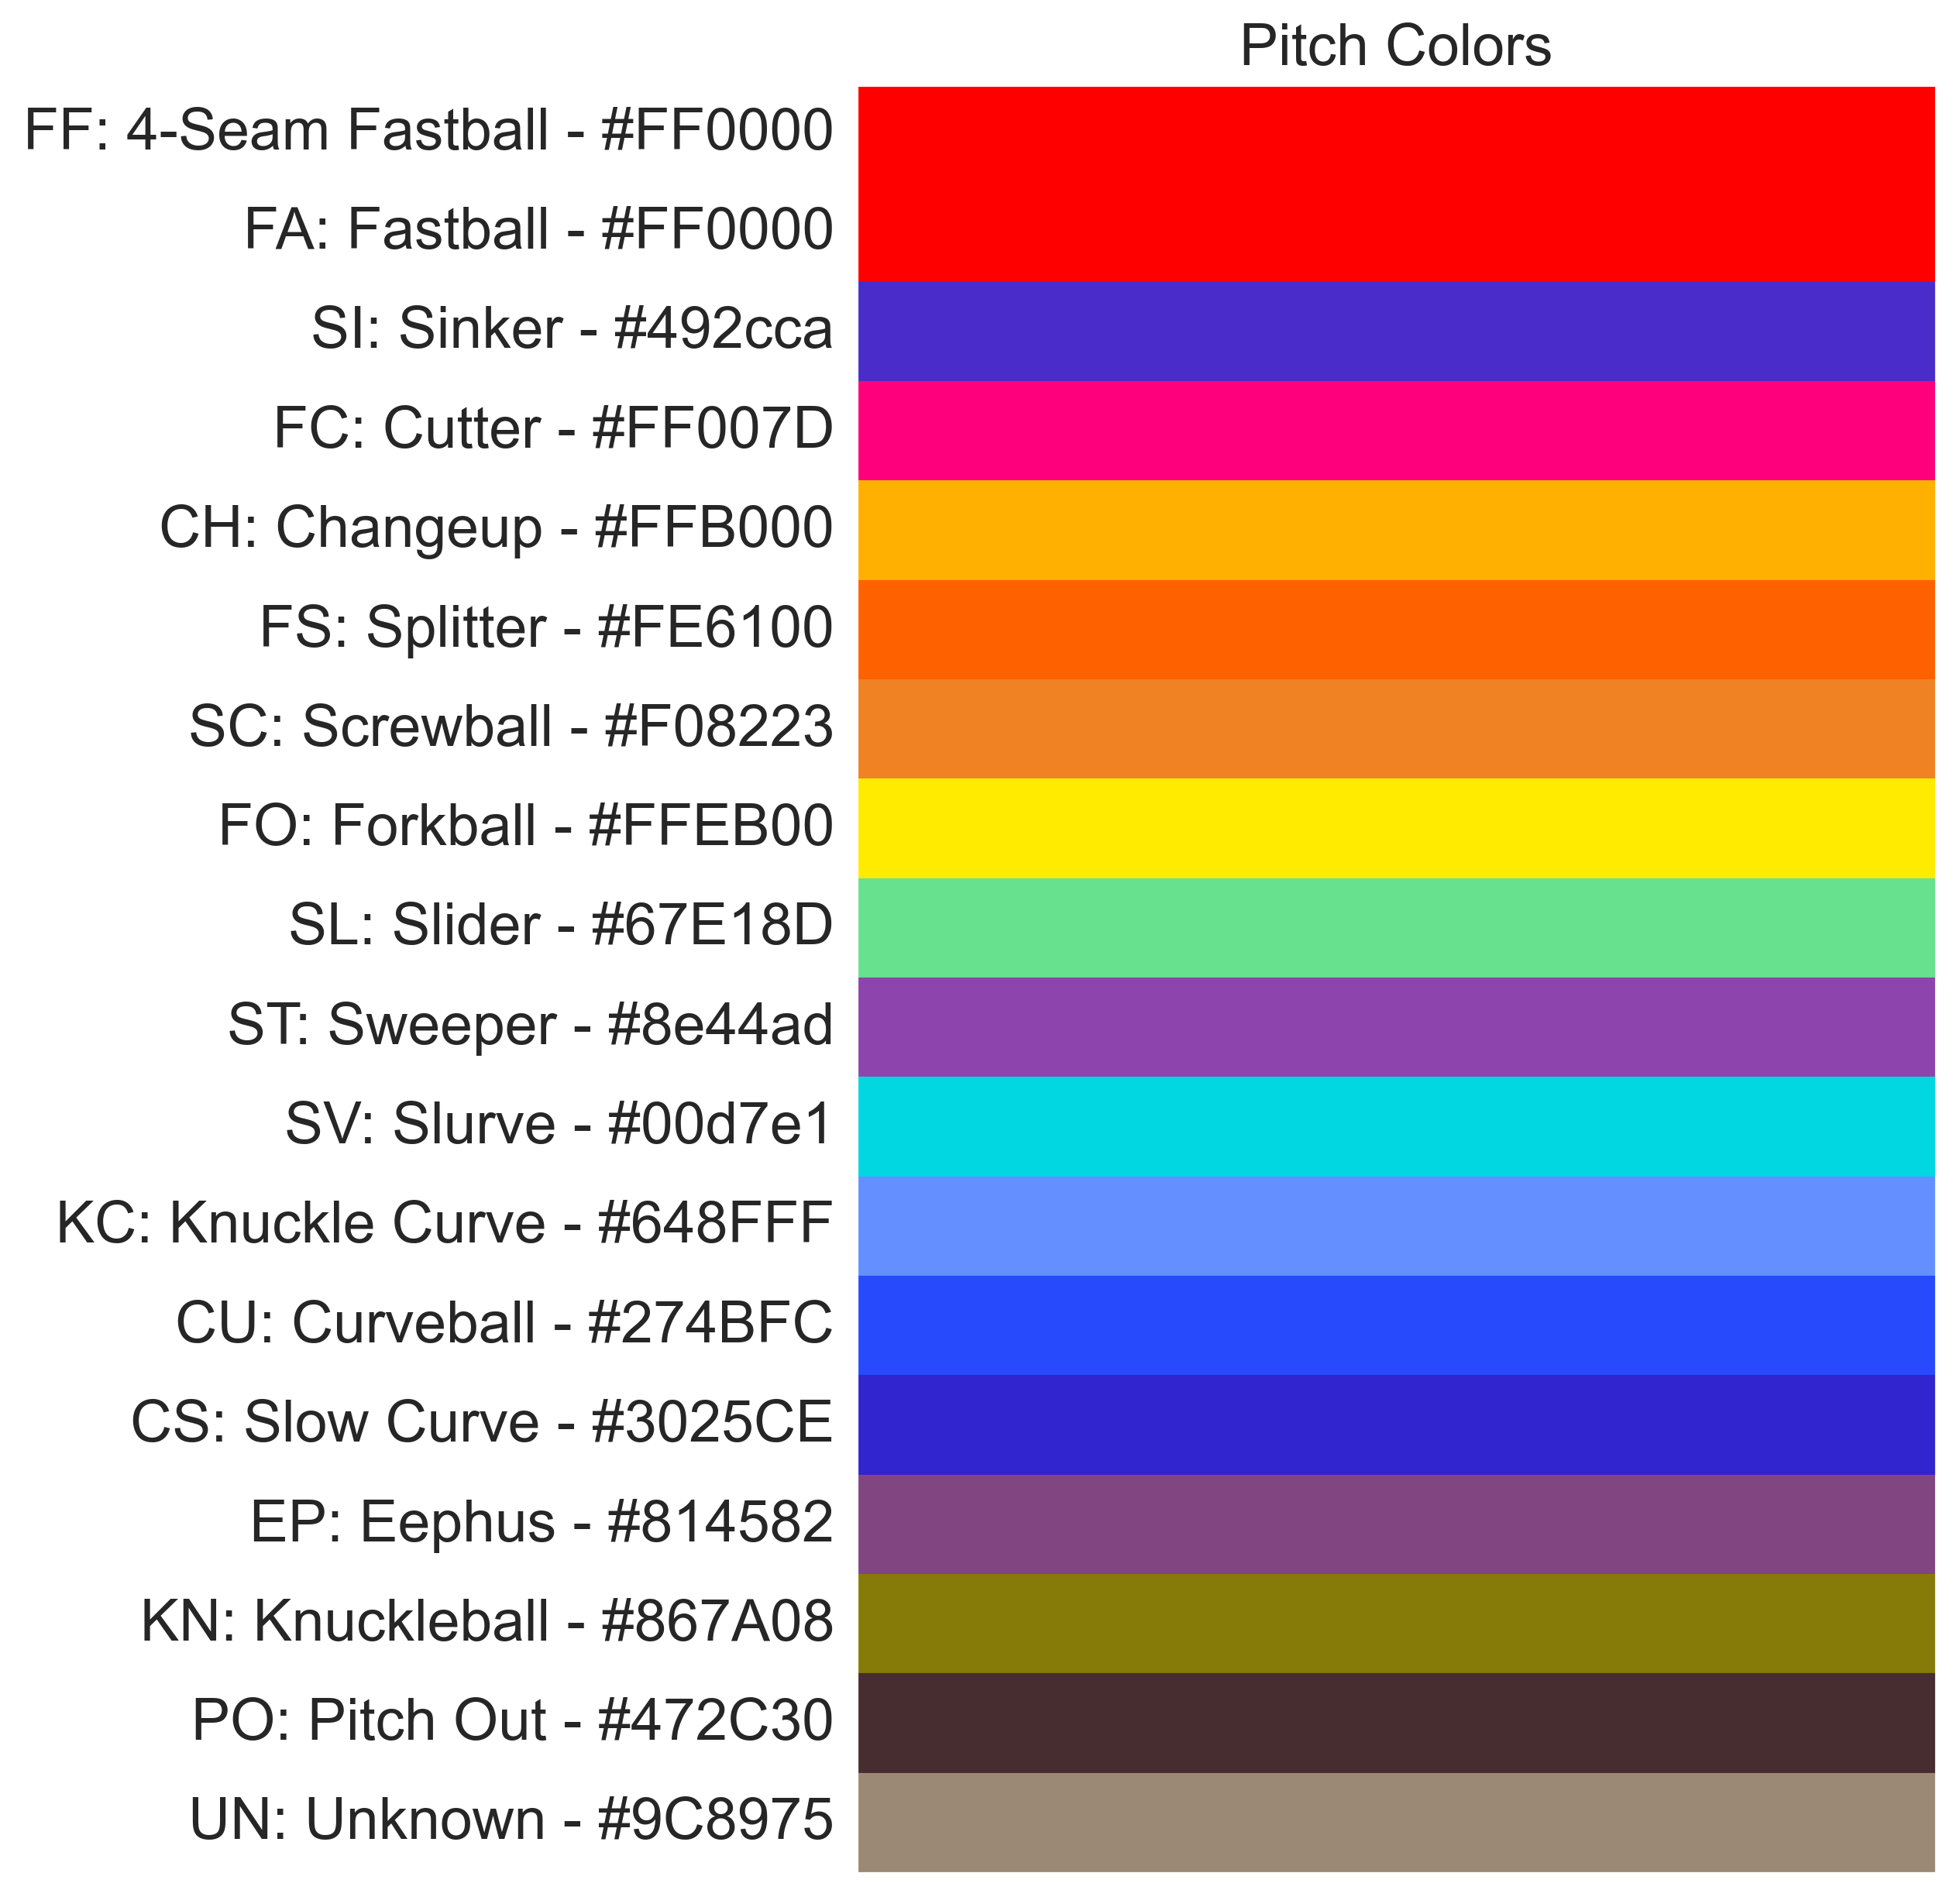

In [13]:
### PITCH COLOURS ###
pitch_colours = {
    ## Fastballs ##
    'FF': {'colour': '#FF0000', 'name': '4-Seam Fastball'},
    'FA': {'colour': '#FF0000', 'name': 'Fastball'},
    'SI': {'colour': '#492cca', 'name': 'Sinker'},
    'FC': {'colour': '#FF007D', 'name': 'Cutter'},

    ## Offspeed ##
    'CH': {'colour': '#FFB000', 'name': 'Changeup'},
    'FS': {'colour': '#FE6100', 'name': 'Splitter'},
    'SC': {'colour': '#F08223', 'name': 'Screwball'},
    'FO': {'colour': '#FFEB00', 'name': 'Forkball'},

    ## Sliders ##
    'SL': {'colour': '#67E18D', 'name': 'Slider'},
    'ST': {'colour': '#8e44ad', 'name': 'Sweeper'},
    'SV': {'colour': '#00d7e1', 'name': 'Slurve'},

    ## Curveballs ##
    'KC': {'colour': '#648FFF', 'name': 'Knuckle Curve'},
    'CU': {'colour': '#274BFC', 'name': 'Curveball'},
    'CS': {'colour': '#3025CE', 'name': 'Slow Curve'},
    'EP': {'colour': '#814582', 'name': 'Eephus'},

    ## Others ##
    'KN': {'colour': '#867A08', 'name': 'Knuckleball'},
    'PO': {'colour': '#472C30', 'name': 'Pitch Out'},
    'UN': {'colour': '#9C8975', 'name': 'Unknown'},
}

# Create a dictionary mapping pitch types to their colors
dict_colour = dict(zip(pitch_colours.keys(), [pitch_colours[key]['colour'] for key in pitch_colours]))

# Create a dictionary mapping pitch types to their colors
dict_pitch = dict(zip(pitch_colours.keys(), [pitch_colours[key]['name'] for key in pitch_colours]))

import matplotlib.pyplot as plt
# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 10))

# Plot a square for each pitch type with its corresponding color
for i, pitch_type in enumerate(pitch_colours):
    ax.add_patch(plt.Rectangle((0, i), 1, 1, color=pitch_colours[pitch_type]['colour']))
    ax.text(-0.02, i + 0.5, f'{pitch_type}: {pitch_colours[pitch_type]["name"]} - {pitch_colours[pitch_type]["colour"]}', va='center', ha='right')

# Set the y-axis limits and remove ticks
ax.set_ylim(0, len(pitch_colours))
ax.set_yticks([])
ax.set_ylabel('')

# Remove the x-axis
ax.set_xticks([])
ax.set_xlabel('')
ax.invert_yaxis()

# Set the title
ax.set_title('Pitch Colors')

# Show the plot
plt.show()

In [14]:
df_player = scraper.get_players(sport_id=1,season=2025,game_type=['S'])
name = 'Hunter Greene' 
specific_player = df_player.filter(df_player['name'] == name)
print(specific_player)

shape: (1, 6)
┌───────────┬────────────┬───────────┬───────────────┬──────────┬──────┐
│ player_id ┆ first_name ┆ last_name ┆ name          ┆ position ┆ team │
│ ---       ┆ ---        ┆ ---       ┆ ---           ┆ ---      ┆ ---  │
│ i64       ┆ str        ┆ str       ┆ str           ┆ str      ┆ i64  │
╞═══════════╪════════════╪═══════════╪═══════════════╪══════════╪══════╡
│ 668881    ┆ Christian  ┆ Greene    ┆ Hunter Greene ┆ P        ┆ 113  │
└───────────┴────────────┴───────────┴───────────────┴──────────┴──────┘


In [79]:

player_id = 668881
selected_date = '2025-04-07' 
season = 2025
player_games = scraper.get_player_games_list(player_id=player_id, season=season, game_type=['R'], pitching=True)

data = scraper.get_data(game_list_input=player_games)
df = scraper.get_data_df(data_list=data)

df = df.filter(
        (pl.col("pitcher_id") == player_id) & 
        (pl.col("game_date") == selected_date)
)
df = df.to_pandas()
pitcher_id = player_id
print(df.columns)


This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 3/3 [00:00<00:00,  8.16iteration/s]

Converting Data to Dataframe.
Index(['game_id', 'game_date', 'batter_id', 'batter_name', 'batter_hand',
       'batter_team', 'batter_team_id', 'pitcher_id', 'pitcher_name',
       'pitcher_hand', 'pitcher_team', 'pitcher_team_id', 'ab_number',
       'play_description', 'play_code', 'in_play', 'is_strike', 'is_swing',
       'is_whiff', 'is_out', 'is_ball', 'is_review', 'pitch_type',
       'pitch_description', 'strikes', 'balls', 'outs', 'strikes_after',
       'balls_after', 'outs_after', 'start_speed', 'end_speed', 'sz_top',
       'sz_bot', 'x', 'y', 'ax', 'ay', 'az', 'pfxx', 'pfxz', 'px', 'pz', 'vx0',
       'vy0', 'vz0', 'x0', 'y0', 'z0', 'zone', 'type_confidence', 'plate_time',
       'extension', 'spin_rate', 'spin_direction', 'vb', 'ivb', 'hb',
       'launch_speed', 'launch_angle', 'launch_distance', 'launch_location',
       'trajectory', 'hardness', 'hit_x', 'hit_y', 'index_play', 'play_id',
       'start_time', 'end_time', 'is_pitch', 'type_type', 'type_ab', 'event',
    

In [80]:
import requests
import pandas as pd
import re

def fetch_game_data_for_specific_date(player_id, season, game_date, game_type=None):
    """
    Fetch game data for a pitcher based on player ID, season, and specific game date.

    Parameters:
    - player_id (int): The player ID.
    - season (int): The season year.
    - game_date (str): The specific date in 'YYYY-MM-DD' format.
    - game_type (list): A list of game types (e.g., ['R'] for regular season).
    
    Returns:
    - df (pandas.DataFrame): A DataFrame containing the game data.
    """
    # Validate date format
    date_pattern = re.compile(r'^\d{4}-\d{2}-\d{2}$')
    if not date_pattern.match(game_date):
        raise ValueError(f"game_date {game_date} is not in YYYY-MM-DD format")
    
    # Default to regular season ('R') if no game_type is provided
    if game_type is None:
        game_type = ['R']

    # Convert the game_type list into a comma-separated string
    game_type_str = ','.join([str(x) for x in game_type])

    # Make API call to fetch game data for the pitcher
    url = f'http://statsapi.mlb.com/api/v1/people/{player_id}?hydrate=stats(group=pitching,type=gameLog,season={season},startDate={game_date},endDate={game_date},gameType={game_type_str})'
    response = requests.get(url)
    
    # Check for successful response
    if response.status_code != 200:
        print(f"Error fetching data: {response.status_code}")
        return None
    
    data = response.json()

    # Extract game data from response
    try:
        game_data = data['people'][0]['stats'][0]['splits']  # Adjust based on response structure
    except KeyError:
        print("No game data found.")
        return None

    # Parse and create a DataFrame
    games = []
    for game in game_data:
        game_info = {
            'game_id': game['game']['gamePk'] if 'game' in game and 'gamePk' in game['game'] else None,
            'date': game['game']['date'] if 'game' in game and 'date' in game['game'] else None,
            'opponent': game['opponent']['name'] if 'opponent' in game else None,
            'outs': game['stat']['outs'] if 'stat' in game and 'outs' in game['stat'] else None,
            'innings_pitched': game['stat']['inningsPitched'] if 'stat' in game and 'inningsPitched' in game['stat'] else None,
            'strikeouts': game['stat']['strikeOuts'] if 'stat' in game and 'strikeOuts' in game['stat'] else None,
            'walks': game['stat']['baseOnBalls'] if 'stat' in game and 'baseOnBalls' in game['stat'] else None,
            'earned_runs': game['stat']['earnedRuns'] if 'stat' in game and 'earnedRuns' in game['stat'] else None,
            'hits': game['stat']['hits'] if 'stat' in game and 'hits' in game['stat'] else None,
            'home_runs': game['stat']['homeRuns'] if 'stat' in game and 'homeRuns' in game['stat'] else None,
            'batters_faced': game['stat']['battersFaced'] if 'stat' in game and 'battersFaced' in game['stat'] else None
        }
        games.append(game_info)
    
    # Convert to DataFrame
    df_table = pd.DataFrame(games)
    return df_table

# Example usage:
player_id = player_id  # Example pitcher ID
season = season
game_date = selected_date  # Specific game date
game_type = ['R']  # Specify game type: 'R' for regular season, 'S' for spring training

df_table = fetch_game_data_for_specific_date(player_id, season, game_date, game_type)

# Display the dataframe columns and the first few rows to verify
print(df_table.columns)
print(df_table.head())


Index(['game_id', 'date', 'opponent', 'outs', 'innings_pitched', 'strikeouts',
       'walks', 'earned_runs', 'hits', 'home_runs', 'batters_faced'],
      dtype='object')
   game_id  date              opponent  outs innings_pitched  strikeouts  \
0   778410  None  San Francisco Giants    26             8.2           7   

   walks  earned_runs  hits  home_runs  batters_faced  
0      1            0     4          0             31  


In [81]:
# Apply the formula for each row in the dataframe
yf = 17 / 12 

df['vy_f'] = -np.sqrt(df['vy0']**2 - (2 * df['ay'] * (df['y0'] - yf)))  # vy_f calculation
df['t'] = (df['vy_f'] - df['vy0']) / df['ay']  # time t calculation
df['vz_f'] = df['vz0'] + (df['az'] * df['t'])  # vz_f calculation
df['VAA'] = -np.arctan(df['vz_f'] / df['vy_f']) * (180 / np.pi)  # VAA calculation
df = df.sort_values(by='pitch_type')
# Display the dataframe with VAA column
df.head()  # or use any method to view the updated dataframe


,game_id,game_date,batter_id,batter_name,batter_hand,batter_team,batter_team_id,pitcher_id,pitcher_name,pitcher_hand,...,type_ab,event,event_type,rbi,away_score,home_score,vy_f,t,vz_f,VAA
0,778410,2025-04-07,664774,LaMonte Wade Jr.,L,SF,137,668881,Hunter Greene,R,...,atBat,Lineout,field_out,0.0,0.0,0.0,-130.708754,0.355343,-12.560210,-5.488876
67,778410,2025-04-07,808982,Jung Hoo Lee,L,SF,137,668881,Hunter Greene,R,...,None,None,None,NaN,NaN,NaN,-129.691142,0.357013,-12.771383,-5.624090
65,778410,2025-04-07,642715,Willy Adames,R,SF,137,668881,Hunter Greene,R,...,atBat,Single,single,0.0,0.0,0.0,-132.490801,0.350811,-11.574162,-4.992584
64,778410,2025-04-07,642715,Willy Adames,R,SF,137,668881,Hunter Greene,R,...,None,None,None,NaN,NaN,NaN,-130.152295,0.355705,-11.406711,-5.008677
62,778410,2025-04-07,664774,LaMonte Wade Jr.,L,SF,137,668881,Hunter Greene,R,...,None,None,None,NaN,NaN,NaN,-133.686119,0.348917,-10.892726,-4.658162


In [82]:
yf = 17 / 12 

df['vy_f'] = -np.sqrt(df['vy0']**2 - (2 * df['ay'] * (df['y0'] - yf)))  # vy_f calculation
df['t'] = (df['vy_f'] - df['vy0']) / df['ay']  # time t calculation
df['vx_f'] = df['vx0'] + (df['ax'] * df['t'])  # vx_f calculation
df['HAA'] = -np.arctan(df['vx_f'] / df['vy_f']) * (180 / np.pi)  # HAA calculation
    
    
df.head()  # or use any method to view the updated dataframe


,game_id,game_date,batter_id,batter_name,batter_hand,batter_team,batter_team_id,pitcher_id,pitcher_name,pitcher_hand,...,event_type,rbi,away_score,home_score,vy_f,t,vz_f,VAA,vx_f,HAA
0,778410,2025-04-07,664774,LaMonte Wade Jr.,L,SF,137,668881,Hunter Greene,R,...,field_out,0.0,0.0,0.0,-130.708754,0.355343,-12.560210,-5.488876,1.046930,0.458909
67,778410,2025-04-07,808982,Jung Hoo Lee,L,SF,137,668881,Hunter Greene,R,...,None,NaN,NaN,NaN,-129.691142,0.357013,-12.771383,-5.624090,4.913817,2.169820
65,778410,2025-04-07,642715,Willy Adames,R,SF,137,668881,Hunter Greene,R,...,single,0.0,0.0,0.0,-132.490801,0.350811,-11.574162,-4.992584,4.744058,2.050697
64,778410,2025-04-07,642715,Willy Adames,R,SF,137,668881,Hunter Greene,R,...,None,NaN,NaN,NaN,-130.152295,0.355705,-11.406711,-5.008677,4.985221,2.193527
62,778410,2025-04-07,664774,LaMonte Wade Jr.,L,SF,137,668881,Hunter Greene,R,...,None,NaN,NaN,NaN,-133.686119,0.348917,-10.892726,-4.658162,4.228624,1.811718


In [83]:
df['in_play'].unique()

array([ True, False])

In [84]:

## Classify if an event is a Batted Ball Event 
df['in_play'] = ['True' if 'False'  else np.nan for x in df['launch_speed']]

## Define a 'Total Bases' column to define batted ball outcomes
conditions_tb = [(df['event_type']=='single'),
                 (df['event_type']=='double'),
                 (df['event_type']=='triple'),
                 (df['event_type']=='home_run')]

## Assign 'Total Bases' value to each condition
choices_tb = [1,
              2,
              3,
              4]

## Assign Total Base Value to batted ball events. 0 for all field outs
df['tb'] = np.select(conditions_tb, choices_tb, default=0)

## Define a 'wOBA' column to calculate wOBA for each event 
## We will use this later to compare to our xwOBA metric
conditions_woba = [(df['event_type']=='walk'),
                   (df['event_type']=='hit_by_pitch'),
                   (df['event_type']=='single'),
                   (df['event_type']=='double'),
                   (df['event_type']=='triple'),
                   (df['event_type']=='home_run')]

choices_woba =    [0.684,
                   0.715,
                   0.880,
                   1.261,
                   1.604,
                   2.085]

df['woba'] = np.select(conditions_woba, choices_woba, default=0)

## Filter out all non-batted ball events for training
df_bip = df[~df['in_play'].isnull()].dropna(subset=['launch_speed','launch_angle','in_play'])


## Features for the model will be launch angle, launch speed
features = ['launch_angle','launch_speed']

## Target will be Total Bases

target = 'tb'


In [85]:
df_woba = df.dropna(subset=features)  # Drop rows with NaN in the feature columns

# print(df_woba[features].isna().sum())  # Check if there are still any NaN values in the feature columns



In [86]:
# Drop rows with missing values in the 'launch_angle' or 'launch_speed' columns
df_woba = df_woba.dropna(subset=['launch_angle', 'launch_speed'])

# Drop rows with NaN in the feature columns
df_woba['woba_pred'] = [sum(x) for x in model.predict_proba(df_woba[features]) * ([0, 0.880,1.261,1.604,2.085])]

# Group by pitcher, name, and pitch type and aggregate the required stats
df_woba = df_woba.groupby(['pitcher_id', 'pitcher_name', 'pitch_type']).agg(
    woba_pa=('woba_pred', 'count'),
    wOBAcon=('woba', 'mean'),
    xwOBAcon=('woba_pred', 'mean')
)

# Display the top 20 sorted by xwOBAcon, without filtering out rows with '--' in woba_pa
df_woba[df_woba['xwOBAcon'] >= 0].sort_values(by='xwOBAcon',ascending=False).head(20)


woba_pa   wOBAcon  xwOBAcon
pitcher_id pitcher_name  pitch_type                             
668881     Hunter Greene FS                2  0.630500  0.545083
                         FF               17  0.155294  0.363387
                         SL                4  0.000000  0.247083

In [87]:
df = pd.merge(df, df_woba, on=['pitcher_id', 'pitch_type'], how='left')

print(df.columns)
print(df.head())

Index(['game_id', 'game_date', 'batter_id', 'batter_name', 'batter_hand',
       'batter_team', 'batter_team_id', 'pitcher_id', 'pitcher_name',
       'pitcher_hand', 'pitcher_team', 'pitcher_team_id', 'ab_number',
       'play_description', 'play_code', 'in_play', 'is_strike', 'is_swing',
       'is_whiff', 'is_out', 'is_ball', 'is_review', 'pitch_type',
       'pitch_description', 'strikes', 'balls', 'outs', 'strikes_after',
       'balls_after', 'outs_after', 'start_speed', 'end_speed', 'sz_top',
       'sz_bot', 'x', 'y', 'ax', 'ay', 'az', 'pfxx', 'pfxz', 'px', 'pz', 'vx0',
       'vy0', 'vz0', 'x0', 'y0', 'z0', 'zone', 'type_confidence', 'plate_time',
       'extension', 'spin_rate', 'spin_direction', 'vb', 'ivb', 'hb',
       'launch_speed', 'launch_angle', 'launch_distance', 'launch_location',
       'trajectory', 'hardness', 'hit_x', 'hit_y', 'index_play', 'play_id',
       'start_time', 'end_time', 'is_pitch', 'type_type', 'type_ab', 'event',
       'event_type', 'rbi', 'away_

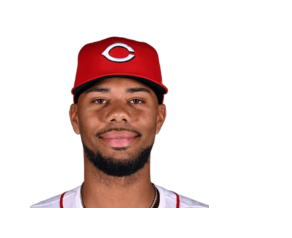

In [88]:
from PIL import Image
import requests
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Function to get an image from a URL and display it on the given axis
def player_headshot(pitcher_id: str, ax: plt.Axes):
    # Construct the URL for the player's headshot image
    url = f'https://img.mlbstatic.com/mlb-photos/image/'\
          f'upload/d_people:generic:headshot:67:current.png'\
          f'/w_640,q_auto:best/v1/people/{pitcher_id}/headshot/silo/current.png'

    # Send a GET request to the URL
    response = requests.get(url)

    # Open the image from the response content
    img = Image.open(BytesIO(response.content))


    # Display the image on the axis
    ax.set_xlim(0, 1.3)
    ax.set_ylim(0, 1)
    ax.imshow(img, extent=[0, 1, 0, 1], origin='upper')

    # Turn off the axis
    ax.axis('off')


# Call the player_headshot function with the pitcher ID and current axis
player_headshot(pitcher_id=pitcher_id, ax=plt.subplots(figsize=(1, 1))[1])

In [89]:
team_colors = {
    'AZ': '#A71930',  # Arizona Diamondbacks: Sedona Red
    'ATH': '#00A04E',
    'ATL': '#CE1141',  # Atlanta Braves: Scarlet
    'BAL': '#DF4601',  # Baltimore Orioles: Orange
    'BOS': '#BD3039',  # Boston Red Sox: Red
    'CHC': '#0E3386',  # Chicago Cubs: Blue
    'CHW': '#C4CED4',  # Chicago White Sox: Black
    'CIN': '#C6011F',  # Cincinnati Reds: Red
    'CLE': '#E50022',  # Cleveland Guardians: Navy Blue
    'COL': '#333366',  # Colorado Rockies: Rockies Purple
    'DET': '#FA4616',  # Detroit Tigers: Navy Blue
    'HOU': '#EB6E1F',  # Houston Astros: Navy Blue
    'KC': '#274BFC',   # Kansas City Royals: Royal Blue
    'LAA': '#003263',  # Los Angeles Angels: Blue
    'LAD': '#005A9C',  # Los Angeles Dodgers: Dodger Blue
    'MIA': '#00A3E0',  # Miami Marlins: Miami Blue
    'MIL': '#B9975B',  # Milwaukee Brewers: Navy Blue
    'MIN': '#D31145',  # Minnesota Twins: Twins Navy Blue
    'NYM': '#FF5910',  # New York Mets: Blue
    'NYY': '#C4CED3',  # New York Yankees: Blue
    'PHI': '#E81828',  # Philadelphia Phillies: Red
    'PIT': '#FDB827',  # Pittsburgh Pirates: Black
    'SD': '#FFC425',   # San Diego Padres: Brown
    'SF': '#FD5A1E',   # San Francisco Giants: Orange
    'SEA': '#005C5C',  # Seattle Mariners: Navy Blue
    'STL': '#C41E3A',  # St. Louis Cardinals: Red
    'TB': '#8FBCE6',   # Tampa Bay Rays: Navy Blue
    'TEX': '#C0111F',  # Texas Rangers: Blue
    'TOR': '#134A8E',  # Toronto Blue Jays: Blue
    'WSH': '#AB0003'   # Washington Nationals: Red
}


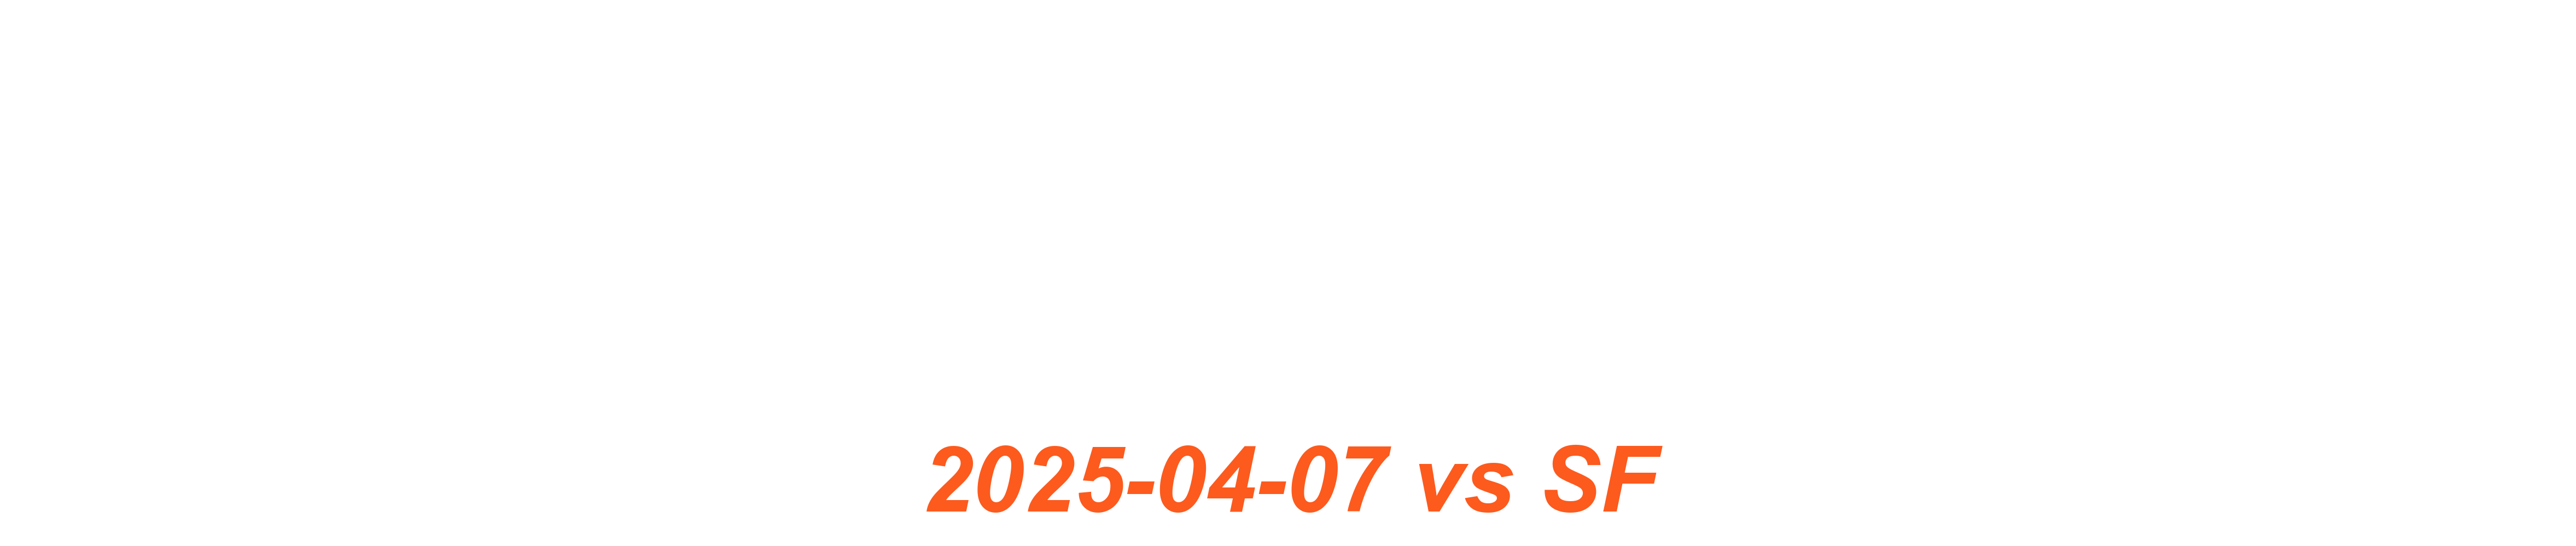

In [90]:

def player_bio(pitcher_id: str, ax: plt.Axes):
    # Construct the URL to fetch player data
    url = f"https://statsapi.mlb.com/api/v1/people?personIds={pitcher_id}&hydrate=currentTeam"

    # Send a GET request to the URL and parse the JSON response
    data = requests.get(url).json()
    if df.empty:
        print("The DataFrame is empty, no data to process.")
    else:
        batter_team = df['batter_team'].values[0]  # Make sure 'df' is properly defined elsewhere
    # Your code continues here...

    # Extract player information from the JSON data
    player_name = data['people'][0]['fullName']
    pitcher_hand = data['people'][0]['pitchHand']['code']
    age = data['people'][0]['currentAge']
    height = data['people'][0]['height']
    weight = data['people'][0]['weight']
    batter_team = df['batter_team'].values[0]  # Make sure 'df' is properly defined elsewhere
    
    # Get the color for the team abbreviation
    team_color = team_colors.get(batter_team, '#FFFFFF')  # Default to white if no color is found

    # Make the background dark and text white
    ax.set_facecolor('#212121')

    ax.text(0.5, 1, f'{player_name}' , va='top', ha='center', fontsize=56, color='white')
    ax.text(0.5, 0.40, f'Throws: {pitcher_hand}   Age:{age}', va='top', ha='center', fontsize=35, color='white')
    ax.text(0.5, 0.675, f'Pitching Performance Summary', va='top', ha='center', fontsize=40, fontstyle='italic', color='white')

    # Color the batter team text based on the team abbreviation
    ax.text(0.5, 0.15, f'{selected_date} vs {batter_team}', va='top', ha='center', fontsize=40, fontweight='bold',fontstyle='italic', color=team_color)

    # Turn off the axis
    ax.axis('off')
    

# Call the player_bio function with the pitcher ID and a new axis of size 10x2
player_bio(pitcher_id, ax=plt.subplots(figsize=(20, 4))[1])


In [91]:
import pandas as pd

# List of MLB teams and their corresponding ESPN logo URLs
mlb_teams = [
    {"team": "AZ", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/ari.png&h=500&w=500"},
    {"team": "ATL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/atl.png&h=500&w=500"},
    {"team": "BAL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/bal.png&h=500&w=500"},
    {"team": "BOS", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/bos.png&h=500&w=500"},
    {"team": "CHC", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/chc.png&h=500&w=500"},
    {"team": "CWS", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/chw.png&h=500&w=500"},
    {"team": "CIN", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/cin.png&h=500&w=500"},
    {"team": "CLE", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/cle.png&h=500&w=500"},
    {"team": "COL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/col.png&h=500&w=500"},
    {"team": "DET", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/det.png&h=500&w=500"},
    {"team": "HOU", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/hou.png&h=500&w=500"},
    {"team": "KC", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/kc.png&h=500&w=500"},
    {"team": "LAA", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/laa.png&h=500&w=500"},
    {"team": "LAD", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/lad.png&h=500&w=500"},
    {"team": "MIA", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/mia.png&h=500&w=500"},
    {"team": "MIL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/mil.png&h=500&w=500"},
    {"team": "MIN", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/min.png&h=500&w=500"},
    {"team": "NYM", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/nym.png&h=500&w=500"},
    {"team": "NYY", "logo_url": "https://a.espncdn.com/guid/2b9cedf3-ce60-0bcf-fafe-8cd055255685/logos/secondary_logo_on_black_color.png"},
    {"team": "ATH", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/oak.png&h=500&w=500"},
    {"team": "PHI", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/phi.png&h=500&w=500"},
    {"team": "PIT", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/pit.png&h=500&w=500"},
    {"team": "SD", "logo_url": "https://a.espncdn.com/guid/4dec648c-3eb9-055c-aebc-2711f30975a0/logos/primary_logo_on_black_color.png"},
    {"team": "SF", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/sf.png&h=500&w=500"},
    {"team": "SEA", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/sea.png&h=500&w=500"},
    {"team": "STL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/stl.png&h=500&w=500"},
    {"team": "TB", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/tb.png&h=500&w=500"},
    {"team": "TEX", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/tex.png&h=500&w=500"},
    {"team": "TOR", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/tor.png&h=500&w=500"},
    {"team": "WSH", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/wsh.png&h=500&w=500"}
]

# Create a DataFrame from the list of dictionaries
df_image = pd.DataFrame(mlb_teams)
image_dict = df_image.set_index('team')['logo_url'].to_dict()

In [92]:
#ARM ANGLE
# import requests
# import re

# def player_bio(pitcher_id: str):
#     # Construct the URL to fetch player data
#     url = f"https://statsapi.mlb.com/api/v1/people?personIds={pitcher_id}&hydrate=currentTeam"

#     # Send a GET request to the URL and parse the JSON response
#     data = requests.get(url).json()

#     # Check if the data is available and contains height
#     if 'people' in data and len(data['people']) > 0:
#         height_str = data['people'][0].get('height', None)
        
#         # Print the height for debugging
#         print(f"Height string: {height_str}")
        
#         if height_str is not None:
#             # Use regex to extract feet and inches from height string like "6' 5\""
#             match = re.match(r"(\d+)' (\d+)\"", height_str)
#             if match:
#                 feet = int(match.group(1))
#                 inches = int(match.group(2))
#                 # Convert the height into decimal feet (e.g., 6' 5" becomes 6.4167 feet)
#                 height_in_decimal = feet + inches / 12
                
#                 # Print the height in decimal format
#                 print(f"Converted height in decimal: {height_in_decimal}")
                
#                 return height_in_decimal
#             else:
#                 print(f"Height format not recognized: {height_str}")
#                 return None
#         else:
#             print(f"Height not found for pitcher {pitcher_id}")
#             return None
#     else:
#         print(f"No data found for pitcher {pitcher_id}")
#         return None


In [93]:
#ARM ANGLE

# def calculate_arm_angle_and_theta(df, decimal_height):
#     # Calculate Adjusted (Adj) using the decimal height in feet
#     df['Adj'] = df['z0'] - (decimal_height * 0.7)  # Use decimal height in feet

#     # Calculate Opp (absolute value of x0, the release point in X)
#     df['Opp'] = np.abs(df['x0'])

#     # Calculate Hyp (hypotenuse)
#     df['Hyp'] = np.sqrt(df['Opp']**2 + df['Adj']**2)

#     # Calculate Angle Θ using the provided formula (arccos formula)
#     df['Angle_Theta'] = np.arccos(
#         (df['Adj']**2 + df['Hyp']**2 - df['Opp']**2) / (2 * df['Adj'] * df['Hyp'])
#     )
    
#     # Convert the angle from radians to degrees for better interpretation
#     df['Angle_Theta'] = np.degrees(df['Angle_Theta'])
#     # df['Angle_Theta'] = 90 - (df['Angle_Theta'])
#     return df

# # Assuming pitcher_id is already defined
# decimal_height = player_bio(pitcher_id)  # Get the height in decimal format from the player_bio function

# # Check if decimal_height is valid (not None) before proceeding
# if decimal_height is not None:
#     df = calculate_arm_angle_and_theta(df, decimal_height)  # Pass the decimal height to the angle calculation function
#     print("Arm angle and theta calculations done.")
#     # Calculate the average arm angle
#     average_arm_angle = df['Angle_Theta'].mean()


#     # Print the average arm angle
#     print(f"Average Arm Angle: {average_arm_angle:.2f} degrees")

# else:
#     print("Height is invalid, cannot proceed with calculations.")

# # Display the updated dataframe to inspect the results
# df.head()  # Use .head() to view the updated dataframe


In [94]:
#ARM ANGLE TRY

# import numpy as np
# import requests
# import re

# def player_bio(pitcher_id: str):
#     # Construct the URL to fetch player data
#     url = f"https://statsapi.mlb.com/api/v1/people?personIds={pitcher_id}&hydrate=currentTeam"

#     # Send a GET request to the URL and parse the JSON response
#     data = requests.get(url).json()

#     # Check if the data is available and contains height
#     if 'people' in data and len(data['people']) > 0:
#         height_str = data['people'][0].get('height', None)
        
#         # Print the height for debugging
#         print(f"Height string: {height_str}")
        
#         if height_str is not None:
#             # Use regex to extract feet and inches from height string like "6' 5\""
#             match = re.match(r"(\d+)' (\d+)\"", height_str)
#             if match:
#                 feet = int(match.group(1))
#                 inches = int(match.group(2))
#                 # Convert the height into decimal feet (e.g., 6' 5" becomes 6.4167 feet)
#                 height_in_decimal = feet + inches / 12
#                 return height_in_decimal
#             else:
#                 print(f"Height format not recognized: {height_str}")
#                 return None
#         else:
#             print(f"Height not found for pitcher {pitcher_id}")
#             return None
#     else:
#         print(f"No data found for pitcher {pitcher_id}")
#         return None

# def calculate_arm_angle_and_theta(df, decimal_height):
#     # Check if df is empty
#     if df.empty:
#         print("DataFrame is empty!")
#         return df

#     print("DataFrame is not empty, proceeding with calculations.")
    
#     # Calculate Adjusted (Adj) using the decimal height in feet
#     df['Adj'] = df['z0'] - (decimal_height * 0.7)  # Use decimal height in feet
#     print(f"Adj (first row): {df['Adj'].iloc[0]}")  # Print first row of Adj

#     # Calculate Opp (absolute value of x0, the release point in X)
#     df['Opp'] = np.abs(df['x0'])
#     print(f"Opp (first row): {df['Opp'].iloc[0]}")  # Print first row of Opp

#     # Calculate Hyp (hypotenuse)
#     df['Hyp'] = np.sqrt(df['Opp']**2 + df['Adj']**2)
#     print(f"Hyp (first row): {df['Hyp'].iloc[0]}")  # Print first row of Hyp

#     # Calculate Angle Θ using the provided formula (arccos formula)
#     df['Angle_Theta'] = np.arccos(
#         (df['Adj']**2 + df['Hyp']**2 - df['Opp']**2) / (2 * df['Adj'] * df['Hyp'])
#     )
#     print(f"Angle_Theta (radians) (first row): {df['Angle_Theta'].iloc[0]}")  # Print first row of Angle Θ in radians

#     # Convert the angle from radians to degrees for better interpretation
#     df['Angle_Theta'] = np.degrees(df['Angle_Theta'])
#     print(f"Angle_Theta (degrees) (first row): {df['Angle_Theta'].iloc[0]}")  # Print first row of Angle Θ in degrees

#     return df

# # Assuming pitcher_id is already defined
# decimal_height = player_bio(pitcher_id)  # Get the height in decimal format from the player_bio function

# # Check if height is valid (not None) before proceeding
# if decimal_height is not None:
#     df = calculate_arm_angle_and_theta(df, decimal_height)  # Pass the decimal height to the angle calculation function
#     print("Arm angle and theta calculations done.")
    
#     # Calculate the average arm angle
#     average_arm_angle = df['Angle_Theta'].mean()
#     print(f"Average Arm Angle: {average_arm_angle:.2f} degrees")
# else:
#     print("Height is invalid, cannot proceed with calculations.")

# # Display the updated dataframe to inspect the results
# df.head()  # Use .head() to view the updated dataframe


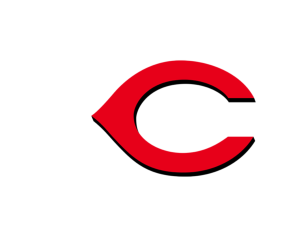

In [95]:
def plot_logo(pitcher_id: str, ax: plt.Axes):
    # Construct the URL to fetch player data
    url = f"https://statsapi.mlb.com/api/v1/people?personIds={pitcher_id}&hydrate=currentTeam"

    # Send a GET request to the URL and parse the JSON response
    data = requests.get(url).json()

    # Construct the URL to fetch team data
    url_team = 'https://statsapi.mlb.com/' + data['people'][0]['currentTeam']['link']

    # Send a GET request to the team URL and parse the JSON response
    data_team = requests.get(url_team).json()

    # Extract the team abbreviation
    team_abb = data_team['teams'][0]['abbreviation']

    # Get the logo URL from the image dictionary using the team abbreviation
    logo_url = image_dict[team_abb]

    # Send a GET request to the logo URL
    response = requests.get(logo_url)

    # Open the image from the response content
    img = Image.open(BytesIO(response.content))

    # Display the image on the axis
    ax.set_xlim(0, 1.3)
    ax.set_ylim(0, 1)
    ax.imshow(img, extent=[0.3, 1.3, 0, 1], origin='upper')

    # Turn off the axis
    ax.axis('off')

# Call the plot_logo function with the pitcher ID and a new axis of size 1x1
plot_logo(pitcher_id, ax=plt.subplots(figsize=(1, 1))[1])

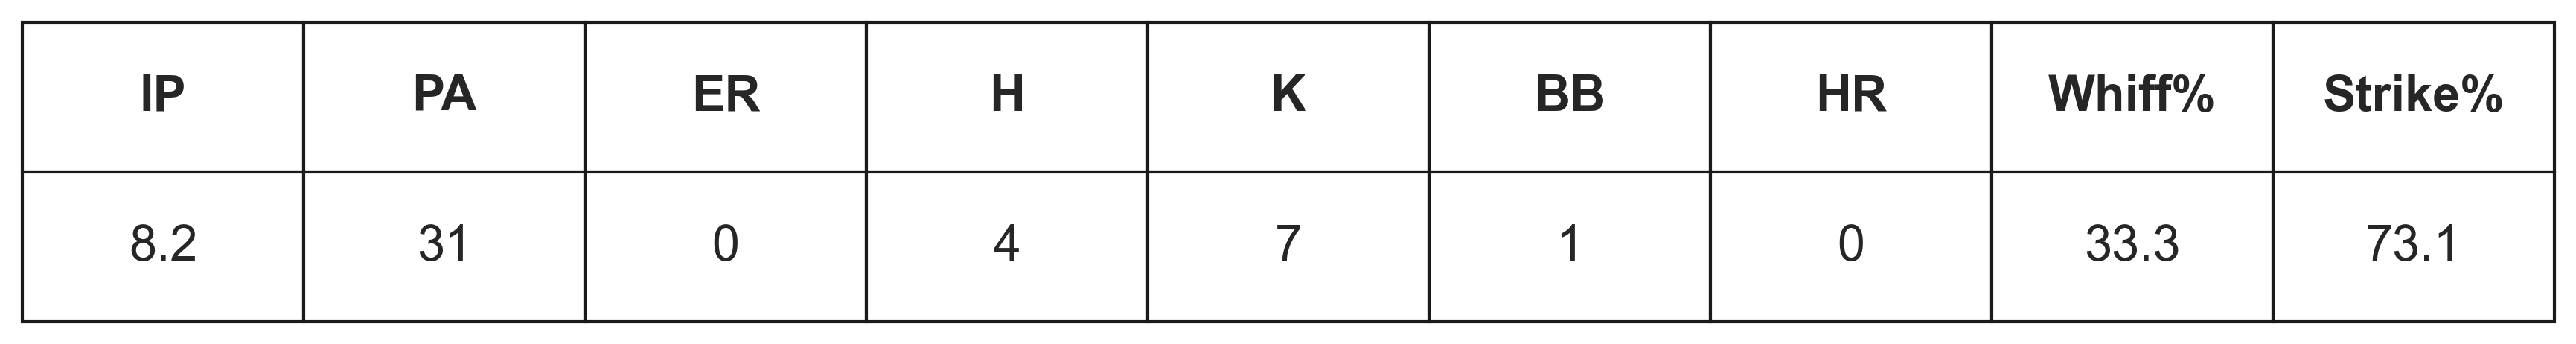

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_whiff_and_strike(df):
    # Calculate whiff percentage (Whiff% = is_whiff / is_swing * 100)
    total_swing = df['is_swing'].sum()
    total_whiff = df['is_whiff'].sum()
    whiff_percentage = (total_whiff / total_swing) * 100 if total_swing > 0 else 0  # Prevent division by 0
    
    # Calculate Strike% using 'play_description' values for strike outcomes
    strike_outcomes = [
        'In play, out(s)', 'Swinging Strike', 'In play, run(s)', 'Foul',
        'Foul Tip', 'Swinging Strike (Blocked)', 'Called Strike', 'In play, no out'
    ]

    # Filter for all pitches that are considered strikes based on play_description
    strike_pitches = df[df['play_description'].isin(strike_outcomes)]

    # Calculate the total number of strikes
    total_strikes = strike_pitches.shape[0]

    # Calculate total pitches
    total_pitches = df['is_pitch'].sum()

    # Calculate Strike% (if total_pitches is greater than 0 to prevent division by 0)
    strike_percentage = (total_strikes / total_pitches) * 100 if total_pitches > 0 else 0  # Prevent division by 0

    return whiff_percentage, strike_percentage

def pitching_table(df, df_table, ax):
    # Calculate Whiff% and Strike% from the 'df' dataframe
    whiff_percentage, strike_percentage = calculate_whiff_and_strike(df)
    
    # Add Whiff% and Strike% as new columns to df_table
    df_table['Whiff%'] = f'{whiff_percentage:.1f}'  # Format to one decimal point
    df_table['Strike%'] = f'{strike_percentage:.1f}'  # Format to one decimal point

    # Rename the columns to match the structure in the table
    df_table = df_table.rename(columns={
        'innings_pitched': 'IP',      # Replace with your column name for innings pitched
        'batters_faced': 'PA',        # Replace with your column name for plate appearances (batters faced)
        'earned_runs': 'ER',           # Replace with your column name for earned runs
        'hits': 'H',                  # Replace with your column name for hits
        'strikeouts': 'K',            # Replace with your column name for strikeouts
        'walks': 'BB',        # Replace with your column name for walks
        'home_runs': 'HR',            # Replace with your column name for home runs
    })

    # Select the relevant columns to display, including Whiff% and Strike%
    df_table = df_table[['IP', 'PA', 'ER', 'H', 'K', 'BB', 'HR', 'Whiff%', 'Strike%']]  # Added 'Whiff%' and 'Strike%'

    # Display the DataFrame as a table on the given axis (ax)
    table = ax.table(cellText=df_table.values, colLabels=df_table.columns, loc='center', cellLoc='center')

    # Adjust table aesthetics
    table.auto_set_font_size(False)
    table.set_fontsize(14)  # Increase font size for better readability

    # Adjust column width
    table.auto_set_column_width(col=list(range(len(df_table.columns))))

    # Add alternating row colors for readability
    for i, key in enumerate(table.get_celld().keys()):
        row, col = key
        if row == 0:
            continue  # Skip the header
        if row % 2 == 0:
            table[(row, col)].set_facecolor('#f2f2f2')  # Light gray for alternate rows

    # Set the table header text to bold
    for cell in table.get_celld().values():
        if cell.get_text() is not None:
            cell.set_text_props(fontweight='bold')
            cell.set_fontsize(14)
            
    table_pb = ax.table(cellText=df_table.values, colLabels=df_table.columns, loc='center', cellLoc='center', bbox=[0, 0, 1, 1])  # Fine-tune this value

    # Make the header cells bold by modifying the text properties
    for i in range(len(df_table.columns)):
        cell = table_pb[(0, i)]  # Header row (row 0)
        cell_text = cell.get_text()  # Get the text object of the cell
        cell_text.set_fontweight('bold')  # Set font weight to bold

    # Hide axes since we are displaying a table
    ax.axis('off')

    return ax

# Example usage:
# Assuming df_table and df are the DataFrames containing your data
fig, ax = plt.subplots(figsize=(12, 2))  # Adjust figure size for better readability
ax = pitching_table(df, df_table, ax)  # Call the function to display the table with Whiff% and Strike%
plt.tight_layout()
plt.show()


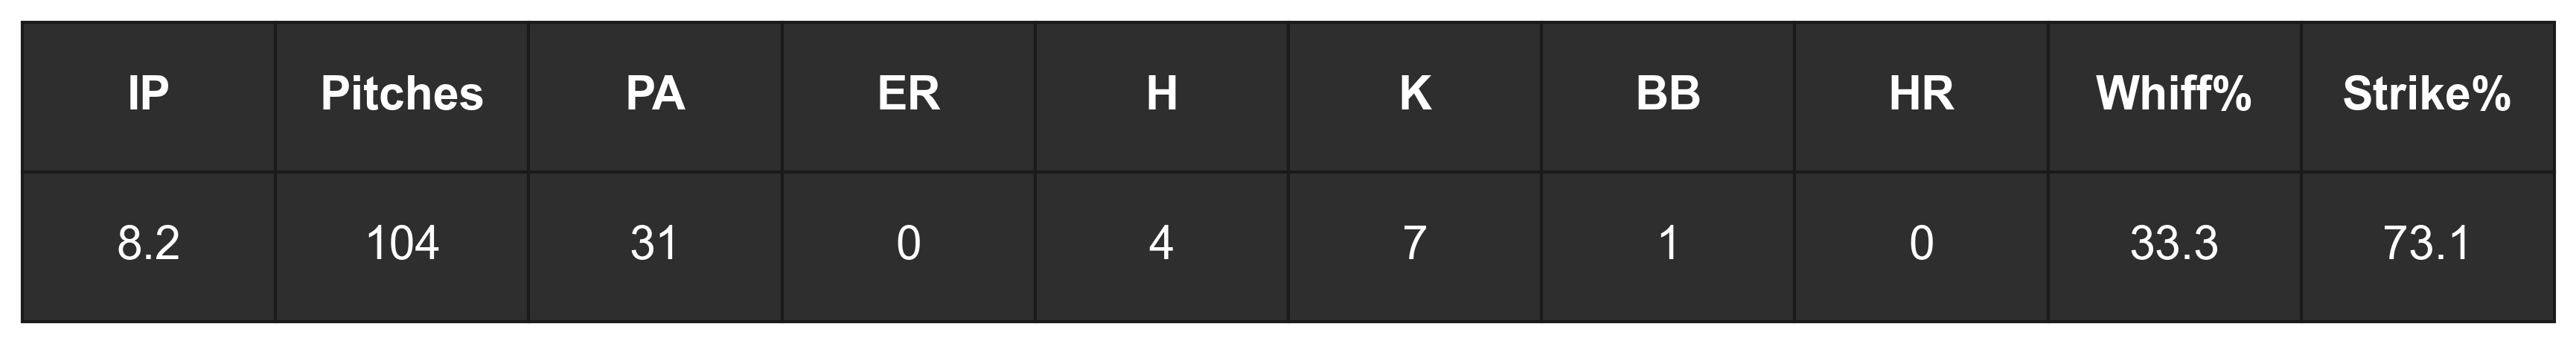

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_whiff_and_strike(df):
    # Calculate whiff percentage (Whiff% = is_whiff / is_swing * 100)
    total_swing = df['is_swing'].sum()
    total_whiff = df['is_whiff'].sum()
    whiff_percentage = (total_whiff / total_swing) * 100 if total_swing > 0 else 0  # Prevent division by 0
    
    # Calculate Strike% using 'play_description' values for strike outcomes
    strike_outcomes = [
        'In play, out(s)', 'Swinging Strike', 'In play, run(s)', 'Foul',
        'Foul Tip', 'Swinging Strike (Blocked)', 'Called Strike', 'In play, no out'
    ]

    # Filter for all pitches that are considered strikes based on play_description
    strike_pitches = df[df['play_description'].isin(strike_outcomes)]

    # Calculate the total number of strikes
    total_strikes = strike_pitches.shape[0]

    # Calculate total pitches
    total_pitches = df['is_pitch'].sum()

    # Calculate Strike% (if total_pitches is greater than 0 to prevent division by 0)
    strike_percentage = (total_strikes / total_pitches) * 100 if total_pitches > 0 else 0  # Prevent division by 0

    return whiff_percentage, strike_percentage

def pitching_table(df, df_table, ax):
    # Calculate Whiff% and Strike% from the 'df' dataframe
    whiff_percentage, strike_percentage = calculate_whiff_and_strike(df)
    
    # Add Whiff% and Strike% as new columns to df_table
    df_table['Whiff%'] = f'{whiff_percentage:.1f}'  # Format to one decimal point
    df_table['Strike%'] = f'{strike_percentage:.1f}'  # Format to one decimal point
    df_table['Pitches'] = df['is_pitch'].sum()  # Add total pitches to the table

    # Rename the columns to match the structure in the table
    df_table = df_table.rename(columns={
        'innings_pitched': 'IP',      # Replace with your column name for innings pitched
        'batters_faced': 'PA',        # Replace with your column name for plate appearances (batters faced)
        'earned_runs': 'ER',           # Replace with your column name for earned runs
        'hits': 'H',                  # Replace with your column name for hits
        'strikeouts': 'K',            # Replace with your column name for strikeouts
        'walks': 'BB',        # Replace with your column name for walks
        'home_runs': 'HR',            # Replace with your column name for home runs
    })

    # Select the relevant columns to display, including Whiff% and Strike%
    df_table = df_table[['IP','Pitches', 'PA', 'ER', 'H', 'K', 'BB', 'HR', 'Whiff%', 'Strike%']]  # Added 'Whiff%' and 'Strike%'

    # Set dark background for the plot
    ax.set_facecolor('#2e2e2e')  # Dark background for the entire plot

    # Display the DataFrame as a table on the given axis (ax)
    table = ax.table(cellText=df_table.values, colLabels=df_table.columns, loc='center', cellLoc='center')

    # Adjust table aesthetics
    table.auto_set_font_size(False)
    table.set_fontsize(14)  # Increase font size for better readability

    # Adjust column width
    table.auto_set_column_width(col=list(range(len(df_table.columns))))

    # Add alternating row colors for readability
    for i, key in enumerate(table.get_celld().keys()):
        row, col = key
        if row == 0:
            continue  # Skip the header
        if row % 2 == 0:
            table[(row, col)].set_facecolor('#3a3a3a')  # Dark gray for alternate rows in dark mode

    # Set the table header text to bold and white
    for cell in table.get_celld().values():
        if cell.get_text() is not None:
            cell.set_text_props(fontweight='bold', color='white')  # White text in bold
            cell.set_fontsize(14)

    # Make the header cells bold and white
    table_pb = ax.table(cellText=df_table.values, colLabels=df_table.columns, loc='center', cellLoc='center', bbox=[0, 0, 1, 1])  # Fine-tune this value
    for i in range(len(df_table.columns)):
        cell = table_pb[(0, i)]  # Header row (row 0)
        cell_text = cell.get_text()  # Get the text object of the cell
        cell_text.set_fontweight('bold')
        cell.set_facecolor('#2e2e2e')  # Set font weight to bold
        cell_text.set_color('white')  # Set header text to white

    # Set table cell colors for dark mode
    for (i, j), cell in table_pb.get_celld().items():
        if i > 0:  # Skip the header
            if cell.get_facecolor() == (1.0, 1.0, 1.0, 1.0):  # Default white color (cells without color)
                cell.set_facecolor('#2e2e2e')  # Set dark background for empty cells
                cell.set_text_props(color='white')  # Set white text for these cells

    # Hide axes since we are displaying a table
    ax.axis('off')

    return ax

# Example usage:
# Assuming df_table and df are the DataFrames containing your data
fig, ax = plt.subplots(figsize=(12, 2))  # Adjust figure size for better readability
ax = pitching_table(df, df_table, ax)  # Call the function to display the table with Whiff% and Strike%
plt.tight_layout()
plt.show()


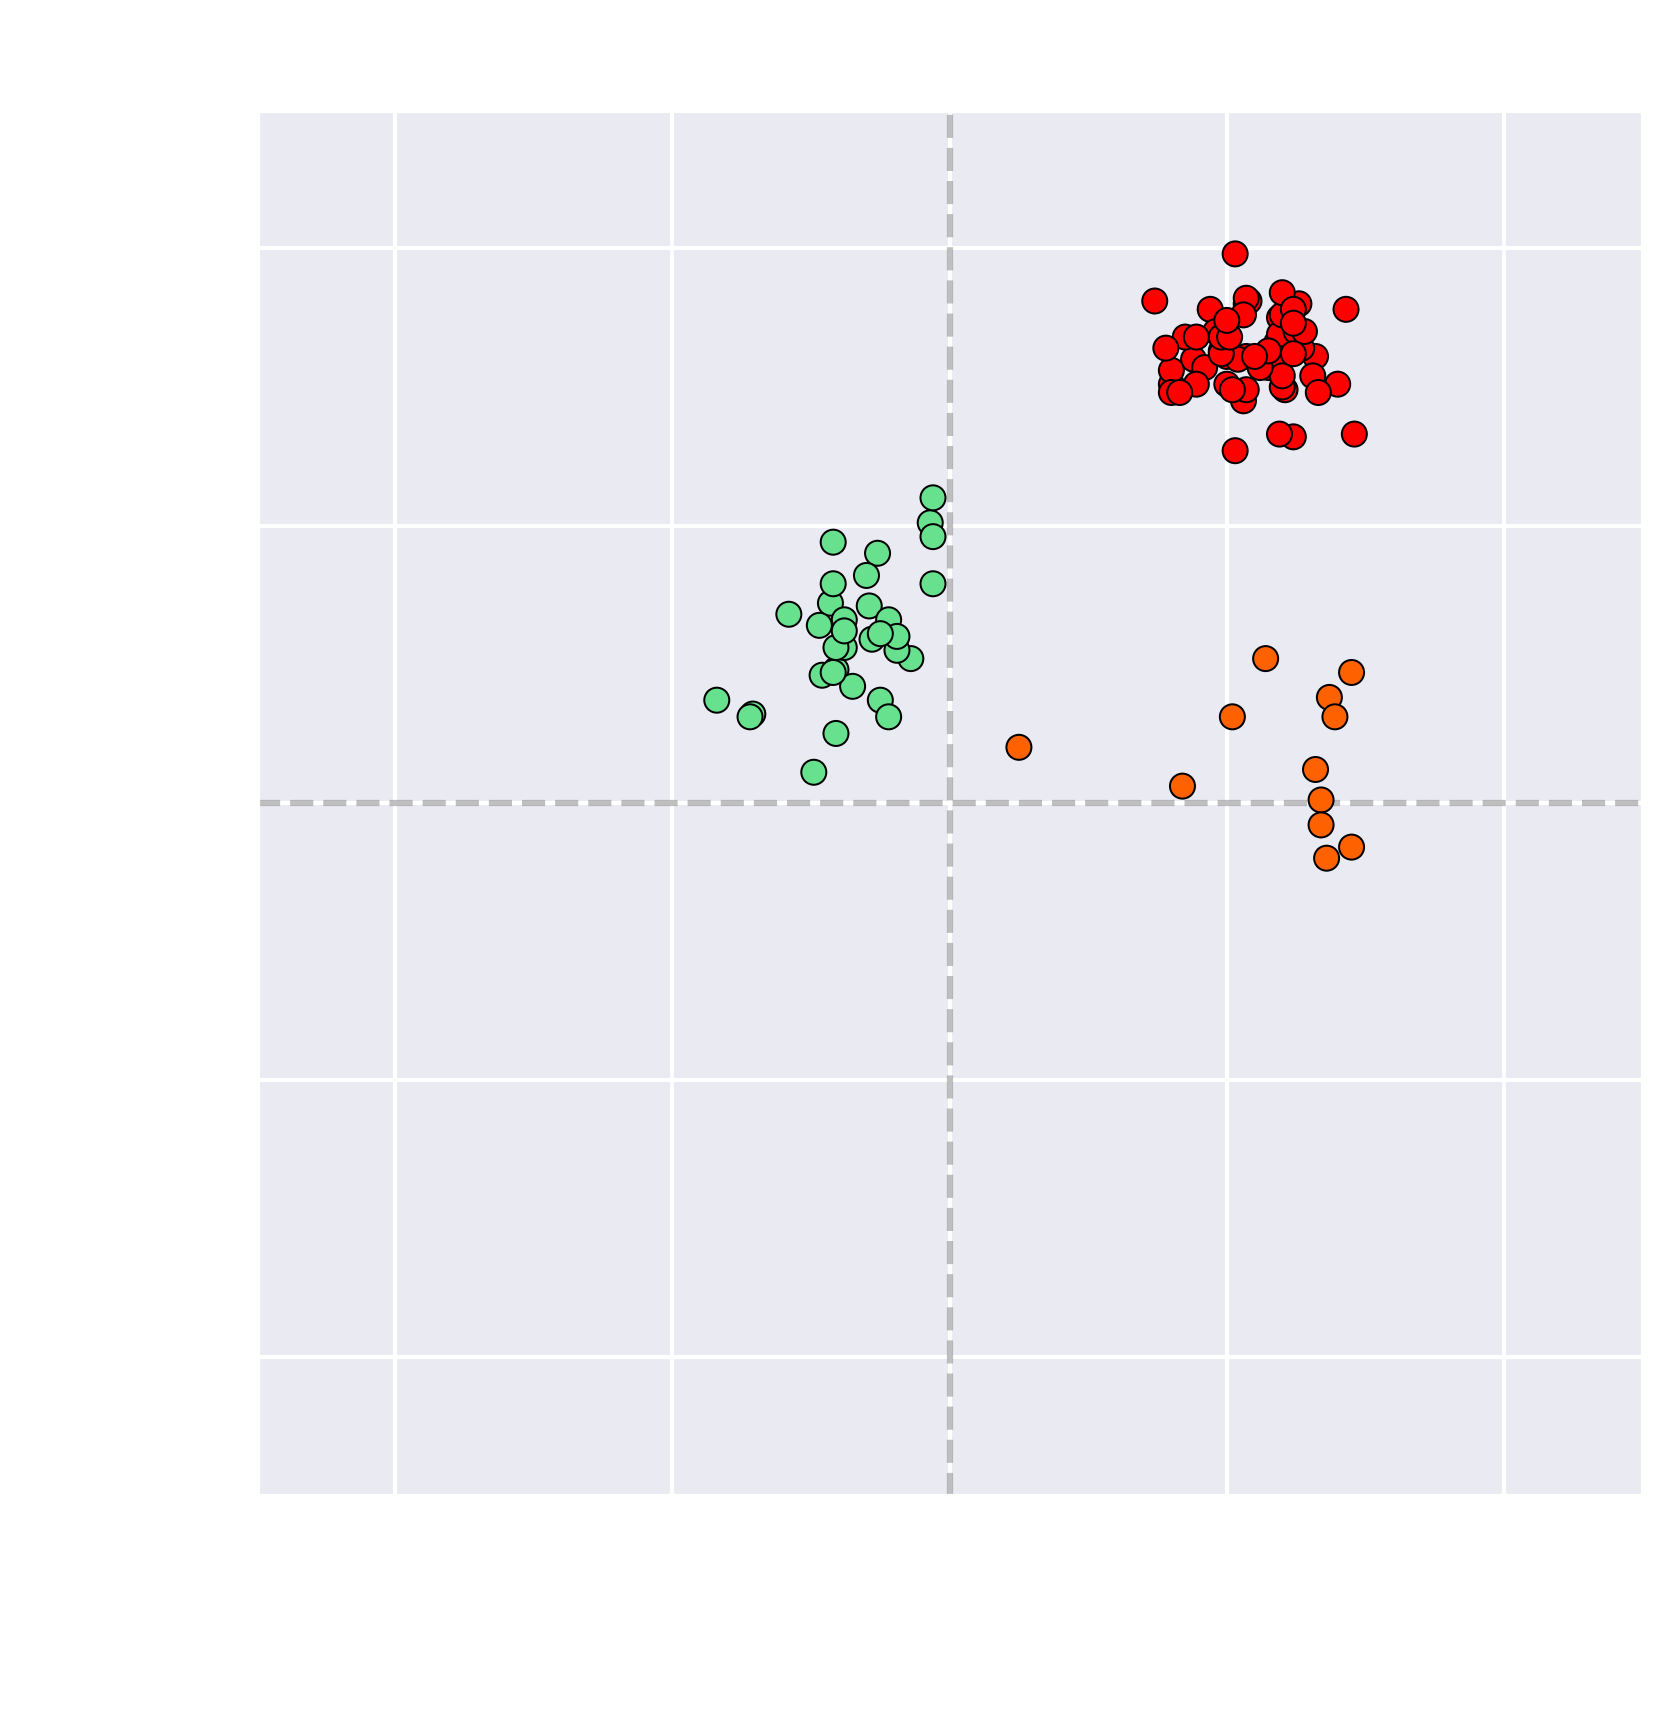

In [98]:
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle, Arc
from matplotlib.lines import Line2D

def break_plot(df: pd.DataFrame, pitcher_id: int, ax: plt.Axes):
    # Scatterplot
    if df['pitcher_hand'][0] == 'R':
        sns.scatterplot(ax=ax,
                        x=df['hb'],
                        y=df['ivb'],
                        hue=df['pitch_type'],
                        palette=dict_colour,
                        ec='black',
                        alpha=1,
                        zorder=2)
    elif df['pitcher_hand'][0] == 'L':
        sns.scatterplot(ax=ax,
                        x=df['hb'],
                        y=df['ivb'],
                        hue=df['pitch_type'],
                        palette=dict_colour,
                        ec='black',
                        alpha=1,
                        zorder=2)
    
    # Draw grid lines at x=0 and y=0
    ax.axhline(y=0, color='#808080', alpha=0.5, linestyle='--', zorder=1)
    ax.axvline(x=0, color='#808080', alpha=0.5, linestyle='--', zorder=1)

    # Axis labels
    ax.set_xlabel('Horizontal Break (in)', color='white')
    ax.set_ylabel('Induced Vertical Break (in)',  color='white')

    # Title
    ax.set_title("Pitch Shapes", color= 'white')

    # Remove the legend for pitch types
    ax.get_legend().remove()

    # Axis tick formatting
    ax.set_xticks(range(-20, 21, 10))
    ax.set_xticklabels(range(-20, 21, 10), color='white')
    ax.set_yticks(range(-20, 21, 10))
    ax.set_yticklabels(range(-20, 21, 10), color='white')

    # Axis limits
    ax.set_xlim((-25, 25))
    ax.set_ylim((-25, 25))

    #Text annotations for arm side vs glove side
    # if df['pitcher_hand'][0] == 'R':
    #     ax.text(-24.2, -24.2, s='← Glove Side', fontstyle='italic', ha='left', va='bottom',
    #             bbox=dict(facecolor='white', edgecolor='black'), fontsize=10, zorder=3)
    #     ax.text(24.2, -24.2, s='Arm Side →', fontstyle='italic', ha='right', va='bottom',
    #             bbox=dict(facecolor='white', edgecolor='black'), fontsize=10, zorder=3)

    # if df['pitcher_hand'][0] == 'L':
    #     ax.invert_xaxis()
    #     ax.text(24.2, -24.2, s='← Arm Side', fontstyle='italic', ha='left', va='bottom',
    #             bbox=dict(facecolor='white', edgecolor='black'), fontsize=10, zorder=3)
    #     ax.text(-24.2, -24.2, s='Glove Side →', fontstyle='italic', ha='right', va='bottom',
    #             bbox=dict(facecolor='white', edgecolor='black'), fontsize=10, zorder=3)

    # Keep aspect ratio square
    ax.set_aspect('equal', adjustable='box')
    #now show the legend and format
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Pitch Type')
    # Format tick labels as integers
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

break_plot(df=df, pitcher_id=pitcher_id, ax=plt.subplots(figsize=(6, 6))[1])


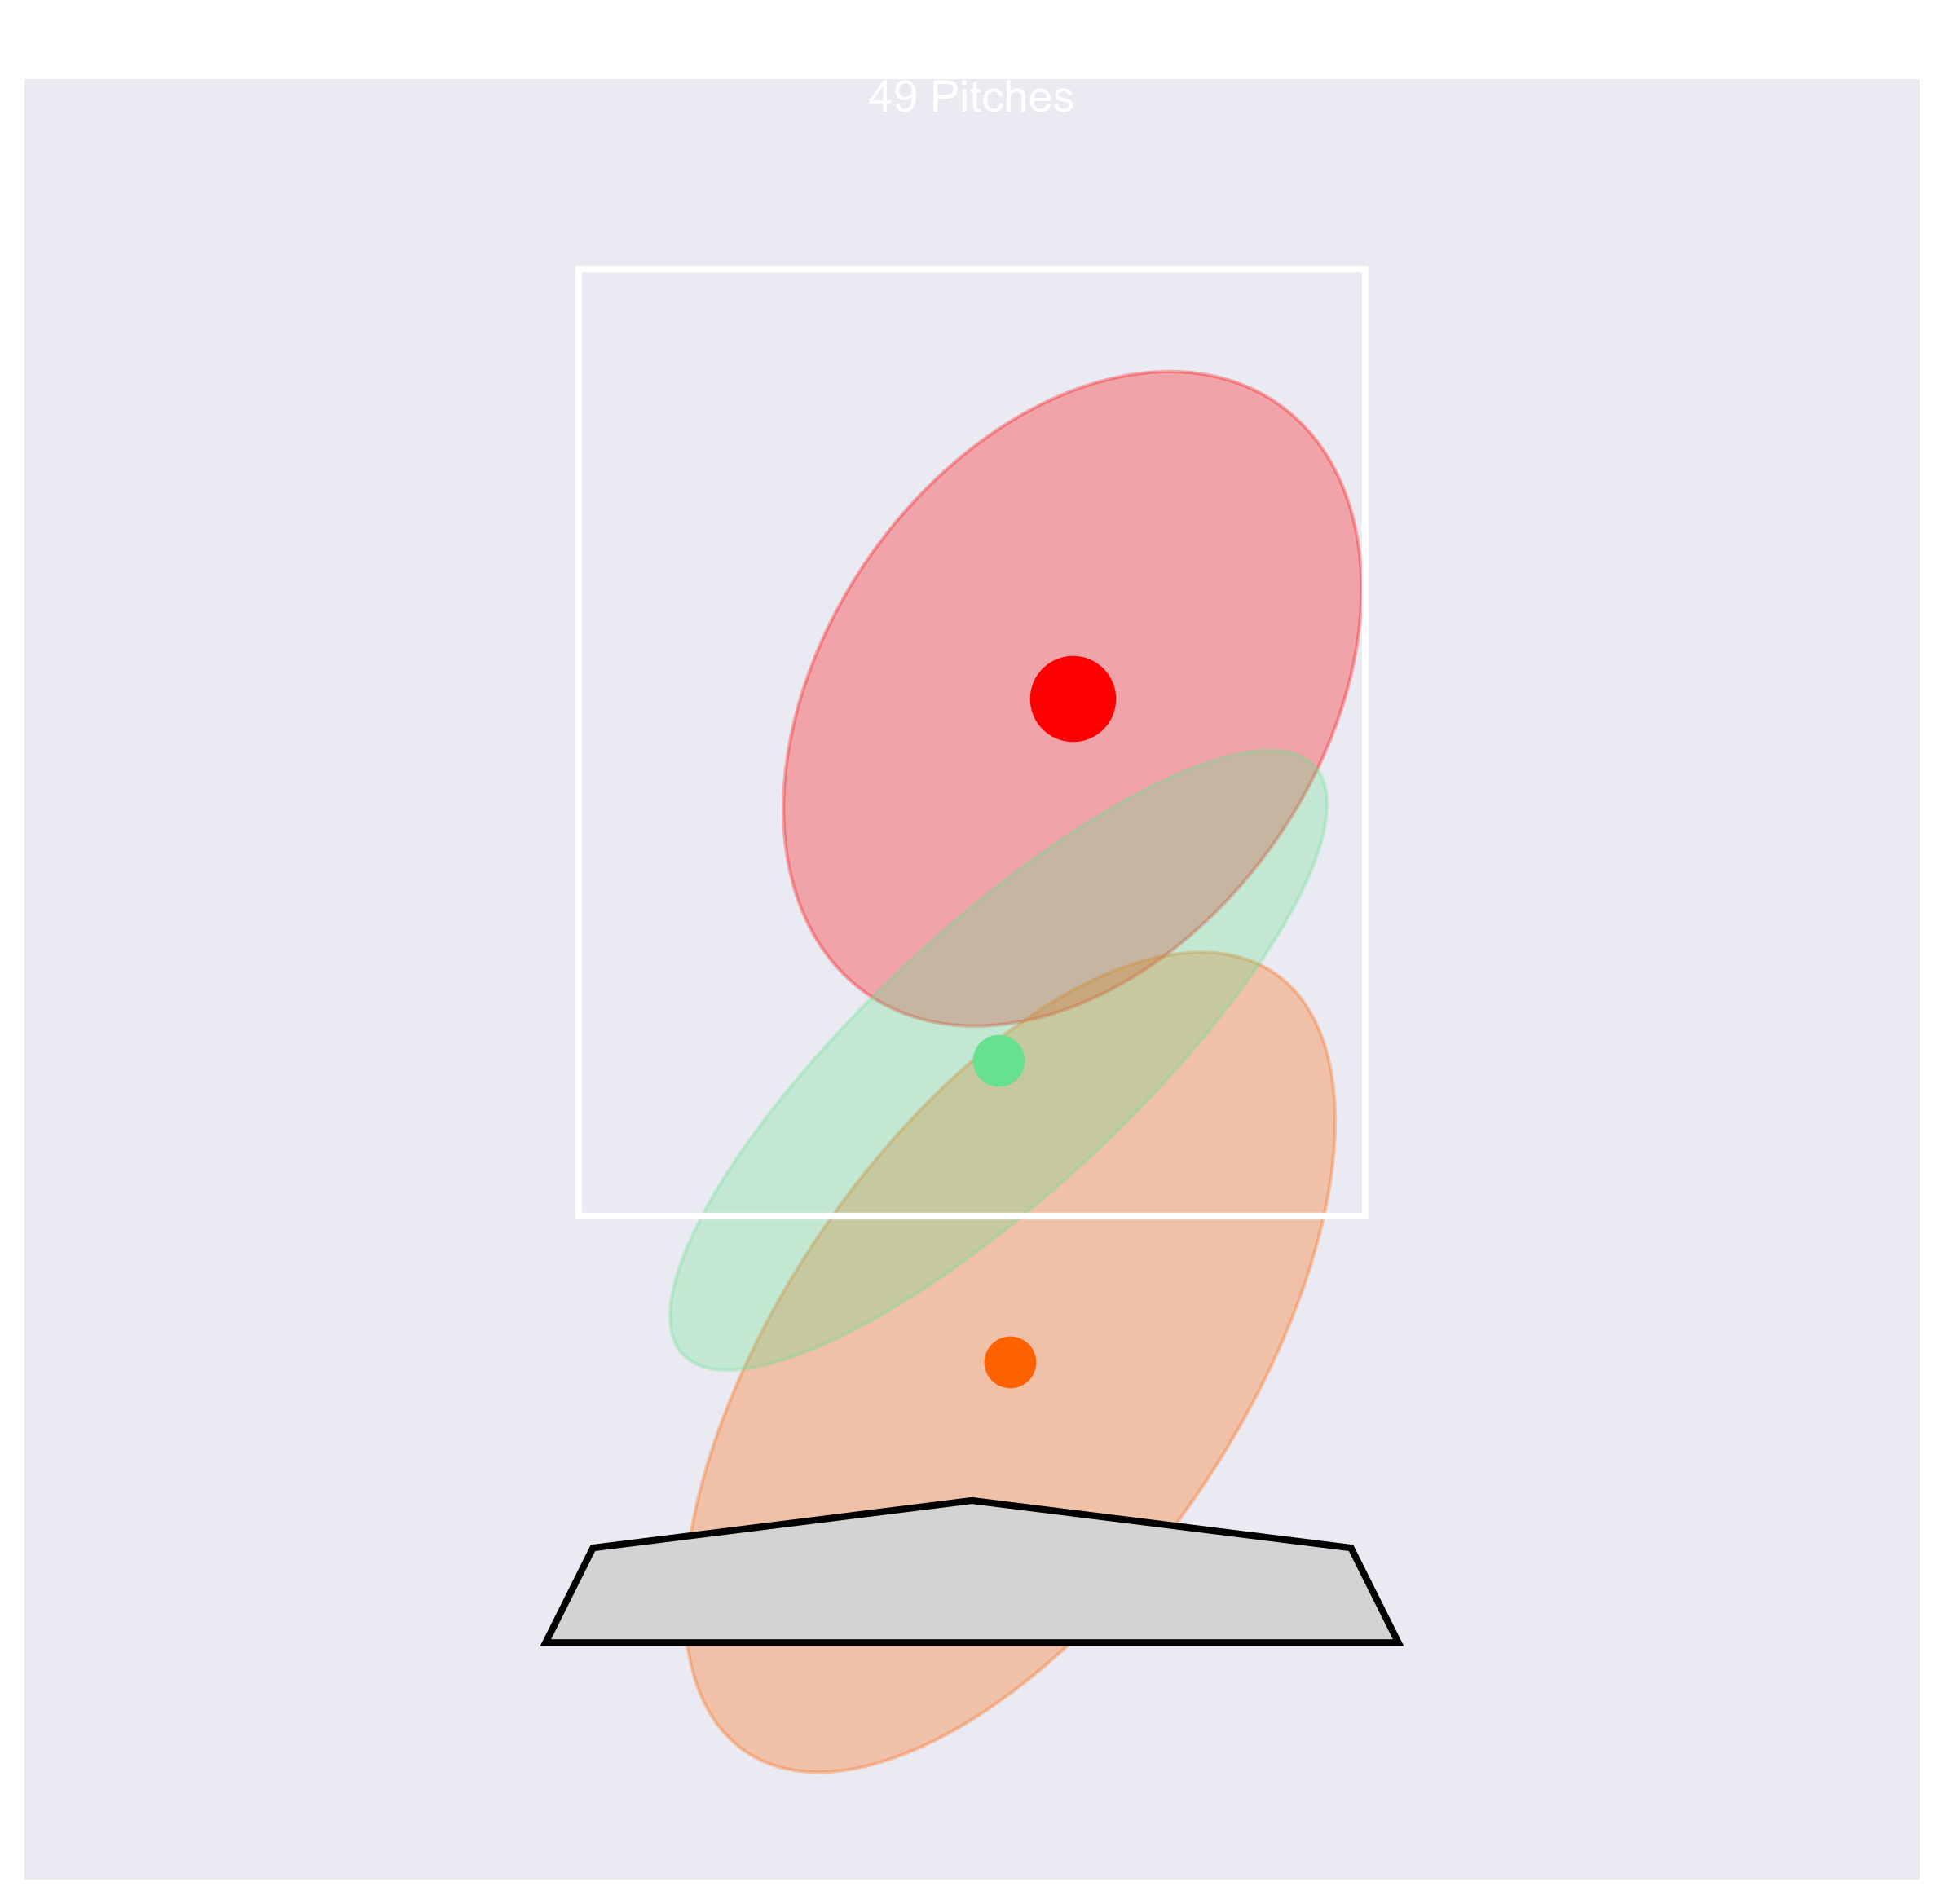

In [99]:
#PANDAS 

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Rectangle, Polygon

def plot_lhb_pitch_locations(df, pitcher_id, ax):
    # Ensure that the 'batter_hand' column is cleaned and set to uppercase using Pandas
    df['batter_hand'] = df['batter_hand'].str.strip().str.upper()  # Clean and capitalize 'batter_hand'
    
    # Filter the DataFrame to get the data for the specified pitcher_id and right-handed batters
    pitcher_data = df[(df['pitcher_id'] == pitcher_id) & (df['batter_hand'] == 'L')]
    
    pitch_type_locations = {}
    total_pitches = len(pitcher_data)

    # Loop through each pitch type
    for pitch_type in pitcher_data['pitch_type'].unique():
        pitch_data = pitcher_data[pitcher_data['pitch_type'] == pitch_type]
        pitch_type_locations[pitch_type] = {
            'locations': pitch_data[['px', 'pz']],  # Use 'px' and 'pz' for plate coordinates
            'count': len(pitch_data)
        }
    
    min_plate_x = -0.83
    max_plate_x = 0.83
    min_plate_z = 1.5
    max_plate_z = 3.5

    # Loop through each pitch type and plot the average location
    for pitch_type, data in pitch_type_locations.items():
        x = data['locations']['px']
        z = data['locations']['pz']
        
        # Calculate the frequency of this pitch type
        pitch_percentage = (data['count'] / total_pitches) * 100
        pitch_count = data['count']
        bubble_size = pitch_percentage * 10  # Adjust bubble size as needed

        # Get the color for this pitch type (default to gray if not found)
        color = pitch_colours.get(pitch_type, {'colour': 'gray'})['colour']
        
        # Check if the pitch percentage is less than 6% and plot accordingly
        if pitch_count < 5:
            # Plot the most frequent location (mean of x, z coordinates) as a dot only
            ax.scatter(x.mean(), z.mean(), color=color, s=bubble_size)
        else:
            # Plot the most frequent location (mean of x, z coordinates) with a dot
            ax.scatter(x.mean(), z.mean(), color=color, s=bubble_size)
            
            # Plot the spread (ellipse) for pitch types thrown more than 6% of the time
            mean_x, mean_z = np.mean(x), np.mean(z)
            cov_matrix = np.cov(x, z)
            v, w = np.linalg.eigh(cov_matrix)
            
            ell_radius_x = np.sqrt(v[0]) * 2
            ell_radius_y = np.sqrt(v[1]) * 2
            
            angle = np.arctan2(*w[:, 0][::-1]) * 180 / np.pi
            ell = Ellipse(xy=(mean_x, mean_z), width=ell_radius_x, height=ell_radius_y, angle=angle,
                          color=color, alpha=0.3)
            ax.add_patch(ell)

    # Draw the strike zone
    strike_zone = Rectangle(
        (min_plate_x, min_plate_z),
        max_plate_x - min_plate_x,   
        max_plate_z - min_plate_z,   
        linewidth=2,                 
        edgecolor='white',           
        facecolor='none',            
        linestyle='-'                
    )
    ax.add_patch(strike_zone)

    # Draw home plate
    home_plate = Polygon(
        [[-0.8, .8], [0, .9], [0.8, .8], [0.9, .6], [-0.9, .6]],
        closed=True,
        facecolor='lightgray',
        edgecolor='black',
        lw=2
    )
    ax.add_patch(home_plate)
    
    # Adjusted limits to zoom out even more
    ax.set_xlim(-2.0, 2.0)  # Further widening the x-axis range
    ax.set_ylim(0.1, 3.9)   # Further widening the y-axis range

    ax.set_aspect('equal', 'box')
    ax.set_title(f'Pitch Type Locations VS LHB', fontsize=14)
    ax.text(0, 3.9, f'{total_pitches} Pitches', fontsize=13, ha='center', va='top', color='white')
    #set font color to white
    ax.title.set_color('white')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.invert_xaxis()
# Remove the border (spines)
    for spine in ax.spines.values():
        spine.set_visible(False)
# Now, the function uses the global pitcher_id, so no need to pass it when calling the function
fig, ax_left = plt.subplots(figsize=(10, 10))
plot_lhb_pitch_locations(df, pitcher_id, ax=ax_left)
plt.show()


In [100]:
# #PANDAS 

# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.patches import Ellipse, Rectangle, Polygon

# def plot_rhb_pitch_locations(df, pitcher_id, ax):
#     # Ensure that the 'batter_hand' column is cleaned and set to uppercase using Pandas
#     df['batter_hand'] = df['batter_hand'].str.strip().str.upper()  # Clean and capitalize 'batter_hand'
    
#     # Filter the DataFrame to get the data for the specified pitcher_id and left-handed batters
#     pitcher_data = df[(df['pitcher_id'] == pitcher_id) & (df['batter_hand'] == 'R')]
    
#     # Check if pitcher_data is empty and handle the case where no data is found
#     # if pitcher_data.empty:
#     #     print(f"No data found for pitcher {pitcher_id} against left-handed batters.")
#     #     return  # Exit if no data is found

#     pitch_type_locations = {}
#     total_pitches = len(pitcher_data)

#     # Loop through each pitch type
#     for pitch_type in pitcher_data['pitch_type'].unique():
#         pitch_data = pitcher_data[pitcher_data['pitch_type'] == pitch_type]
#         pitch_type_locations[pitch_type] = {
#             'locations': pitch_data[['px', 'pz']],  # Use 'px' and 'pz' for plate coordinates
#             'count': len(pitch_data)
#         }
    
#     min_plate_x = -0.63
#     max_plate_x = 0.63
#     min_plate_z = 1.67
#     max_plate_z = 3.3

#     # Loop through each pitch type and plot the average location
#     for pitch_type, data in pitch_type_locations.items():
#         x = data['locations']['px']
#         z = data['locations']['pz']
        
#         # Calculate the frequency of this pitch type
#         pitch_percentage = (data['count'] / total_pitches) * 100
#         bubble_size = pitch_percentage * 10  # Adjust bubble size as needed
        
#         # Check if the pitch percentage is less than 6% and plot accordingly
#         if pitch_percentage < 6:
#             # Plot the most frequent location (mean of x, z coordinates) as a dot only
#             ax.scatter(x.mean(), z.mean(), color=pitch_colours[pitch_type]['colour'], s=bubble_size)
#         else:
#             if pitch_type in pitch_colours:
#                 color = pitch_colours[pitch_type]['colour']
#             else:
#                 color = 'gray'
            
#             # Plot the most frequent location (mean of x, z coordinates) with a dot
#             ax.scatter(x.mean(), z.mean(), color=color, s=bubble_size)
            
#             # Plot the spread (ellipse) for pitch types thrown more than 6% of the time
#             mean_x, mean_z = np.mean(x), np.mean(z)
#             cov_matrix = np.cov(x, z)
#             v, w = np.linalg.eigh(cov_matrix)
            
#             ell_radius_x = np.sqrt(v[0]) * 2
#             ell_radius_y = np.sqrt(v[1]) * 2
            
#             angle = np.arctan2(*w[:, 0][::-1]) * 180 / np.pi
#             ell = Ellipse(xy=(mean_x, mean_z), width=ell_radius_x, height=ell_radius_y, angle=angle,
#                           color=color, alpha=0.3)
#             ax.add_patch(ell)

#     # Draw the strike zone
#     strike_zone = Rectangle(
#         (min_plate_x, min_plate_z),
#         max_plate_x - min_plate_x,   
#         max_plate_z - min_plate_z,   
#         linewidth=2,                 
#         edgecolor='white',           
#         facecolor='none',            
#         linestyle='-'                
#     )
#     ax.add_patch(strike_zone)

#     # Draw home plate
#     home_plate = Polygon(
#         [[-0.6, .8], [0, .9], [0.6, .8], [0.7, .6], [-0.7, .6]],
#         closed=True,
#         facecolor='lightgray',
#         edgecolor='black',
#         lw=2
#     )
#     ax.add_patch(home_plate)
    
#     ax.set_xlim(-1.325, 1.325)
#     ax.set_ylim(.3, 3.7)
#     ax.set_aspect('equal', 'box')
#     ax.set_title(f'Pitch Type Locations VS RHB', fontsize=14)
#     ax.text(0, 3.675, f'{total_pitches} Pitches', fontsize=13, ha='center', va='top', color='white')
#     #set font color to white
#     ax.title.set_color('white')
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.grid(False)
#     ax.invert_xaxis()
# # Remove the border (spines)
#     for spine in ax.spines.values():
#         spine.set_visible(False)
# # Now, the function uses the global pitcher_id, so no need to pass it when calling the function
# fig, ax_left = plt.subplots(figsize=(10, 10))
# plot_rhb_pitch_locations(df, pitcher_id, ax=ax_left)
# plt.show()


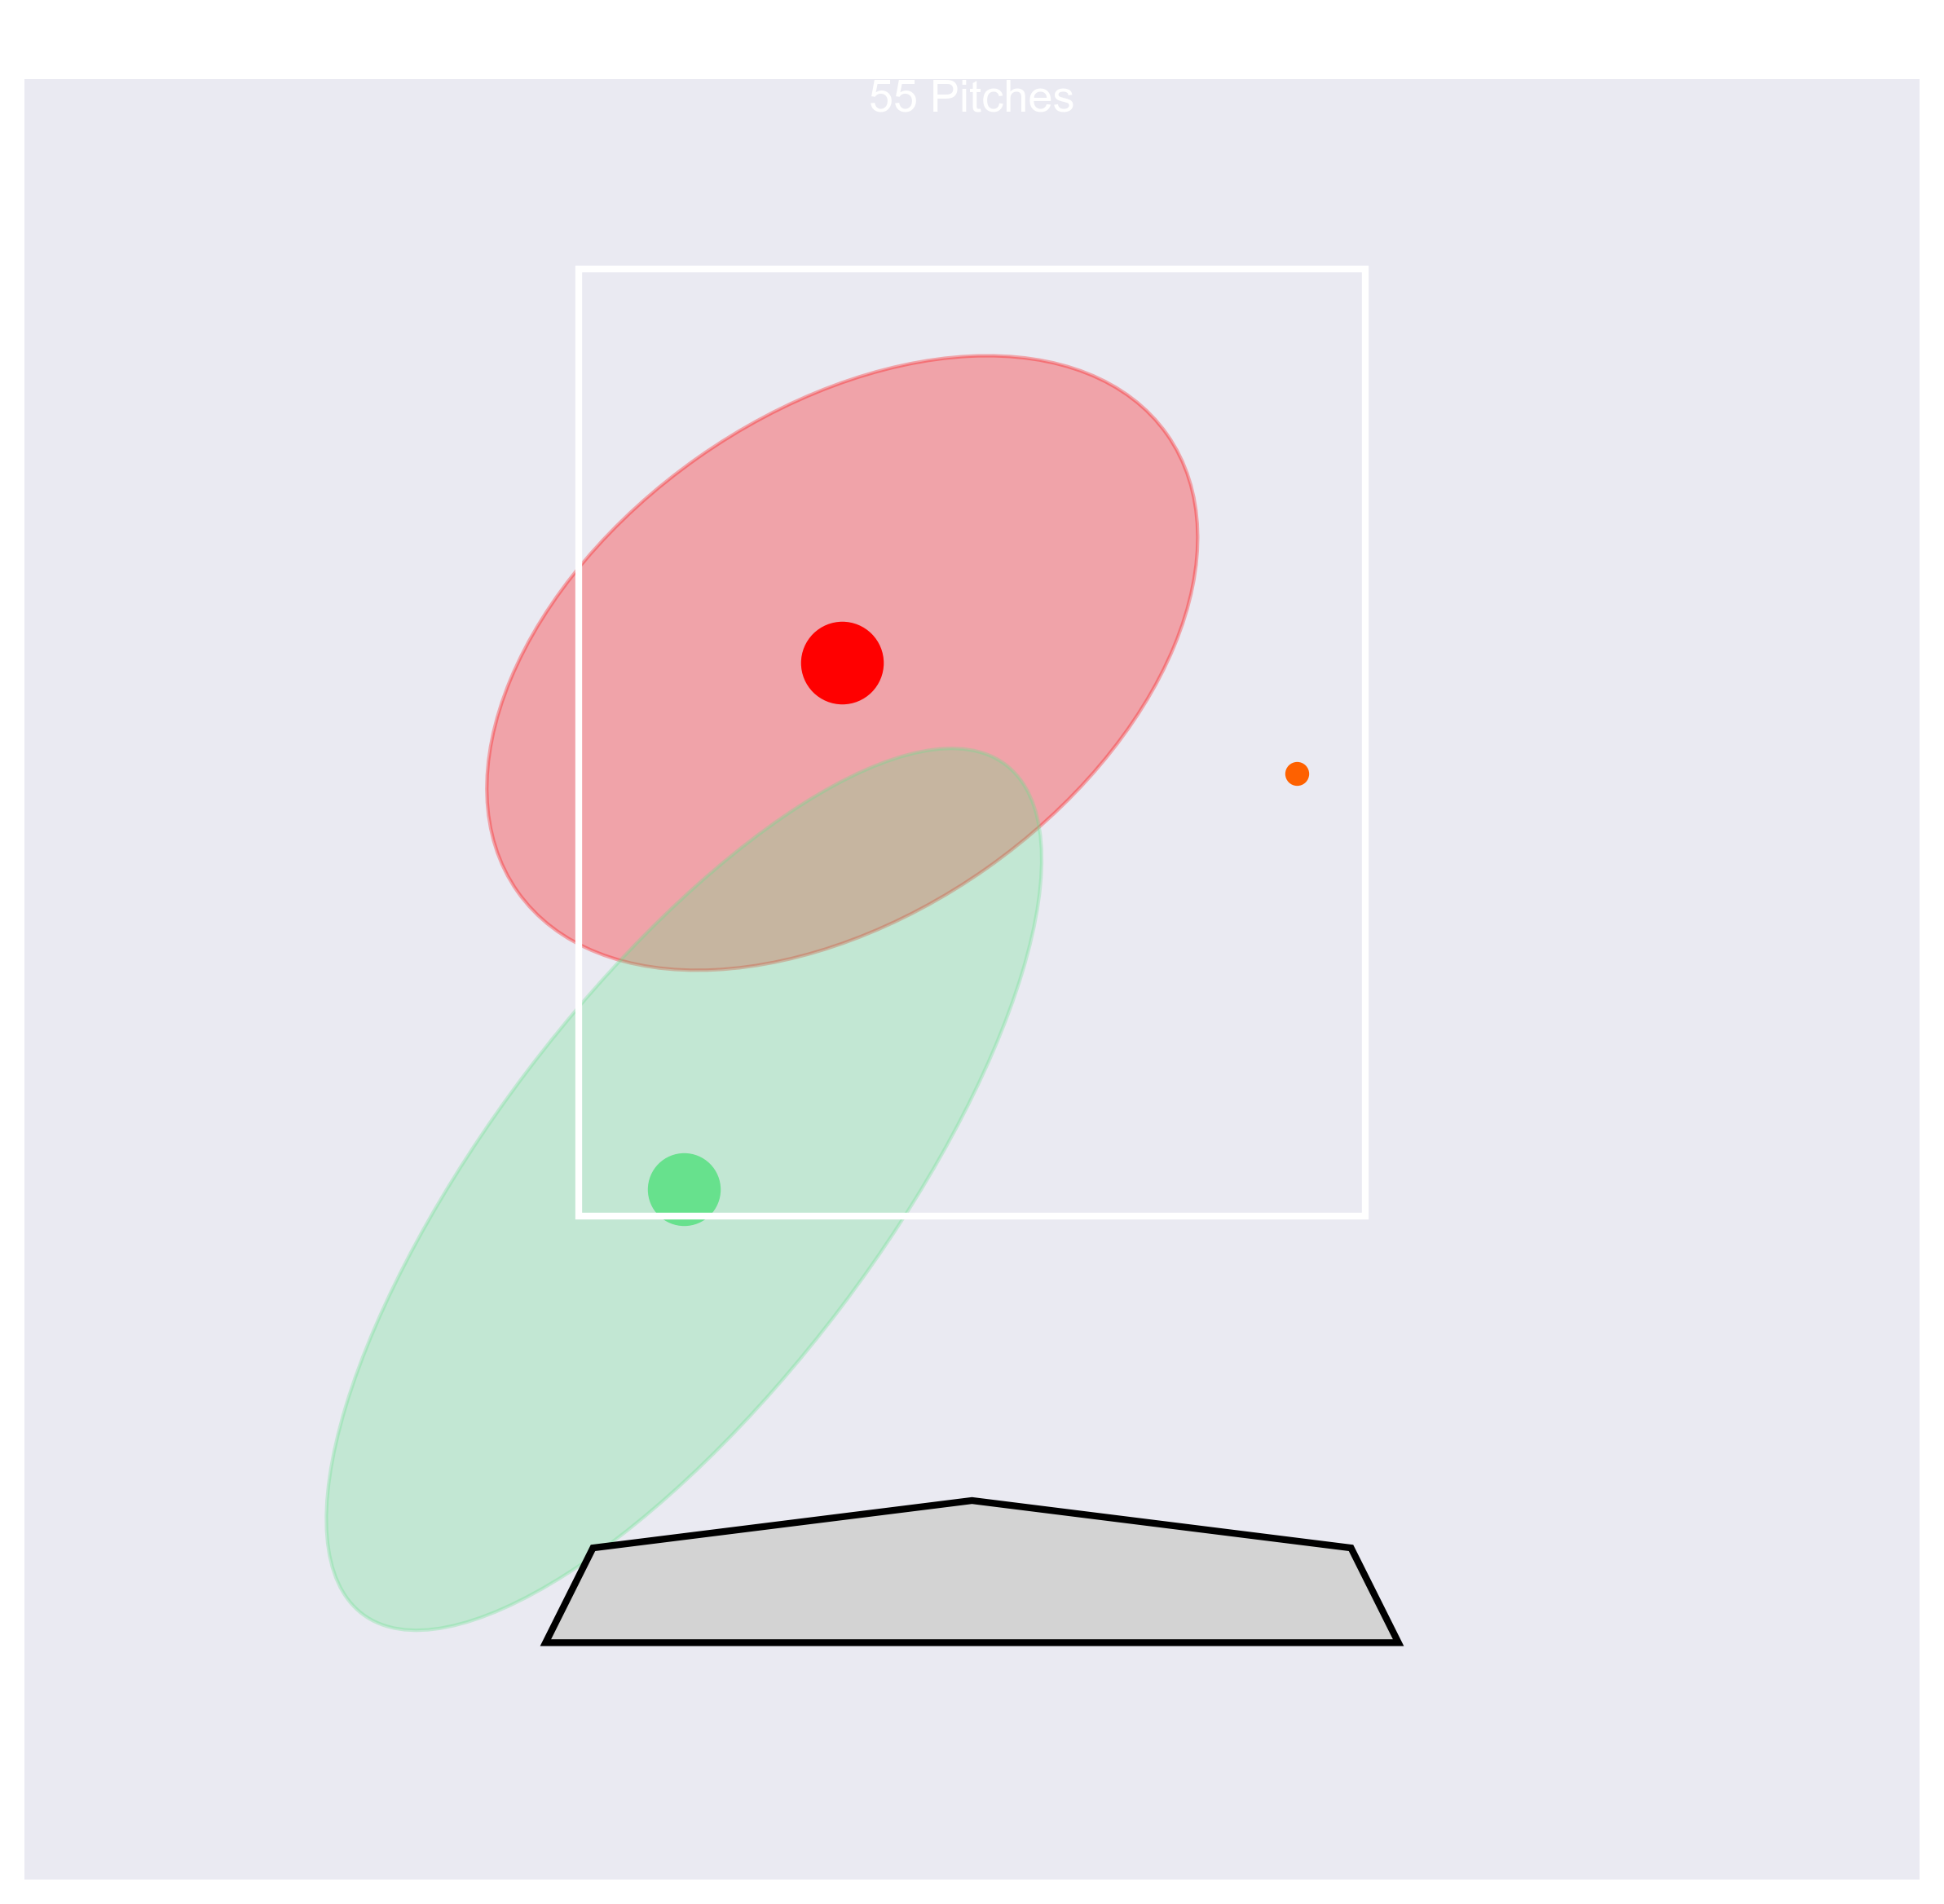

In [101]:
#PANDAS 

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Rectangle, Polygon

def plot_rhb_pitch_locations(df, pitcher_id, ax):
    # Ensure that the 'batter_hand' column is cleaned and set to uppercase using Pandas
    df['batter_hand'] = df['batter_hand'].str.strip().str.upper()  # Clean and capitalize 'batter_hand'
    
    # Filter the DataFrame to get the data for the specified pitcher_id and right-handed batters
    pitcher_data = df[(df['pitcher_id'] == pitcher_id) & (df['batter_hand'] == 'R')]
    
    pitch_type_locations = {}
    total_pitches = len(pitcher_data)

    # Loop through each pitch type
    for pitch_type in pitcher_data['pitch_type'].unique():
        pitch_data = pitcher_data[pitcher_data['pitch_type'] == pitch_type]
        pitch_type_locations[pitch_type] = {
            'locations': pitch_data[['px', 'pz']],  # Use 'px' and 'pz' for plate coordinates
            'count': len(pitch_data)
        }
    
    min_plate_x = -0.83
    max_plate_x = 0.83
    min_plate_z = 1.5
    max_plate_z = 3.5

    # Loop through each pitch type and plot the average location
    for pitch_type, data in pitch_type_locations.items():
        x = data['locations']['px']
        z = data['locations']['pz']
        
        # Calculate the frequency of this pitch type
        pitch_percentage = (data['count'] / total_pitches) * 100
        pitch_count = data['count']
        bubble_size = pitch_percentage * 10  # Adjust bubble size as needed

        # Get the color for this pitch type (default to gray if not found)
        color = pitch_colours.get(pitch_type, {'colour': 'gray'})['colour']
        
        # Check if the pitch percentage is less than 6% and plot accordingly
        if pitch_count < 5:
            # Plot the most frequent location (mean of x, z coordinates) as a dot only
            ax.scatter(x.mean(), z.mean(), color=color, s=bubble_size)
        else:
            # Plot the most frequent location (mean of x, z coordinates) with a dot
            ax.scatter(x.mean(), z.mean(), color=color, s=bubble_size)
            
            # Plot the spread (ellipse) for pitch types thrown more than 6% of the time
            mean_x, mean_z = np.mean(x), np.mean(z)
            cov_matrix = np.cov(x, z)
            v, w = np.linalg.eigh(cov_matrix)
            
            ell_radius_x = np.sqrt(v[0]) * 2
            ell_radius_y = np.sqrt(v[1]) * 2
            
            angle = np.arctan2(*w[:, 0][::-1]) * 180 / np.pi
            ell = Ellipse(xy=(mean_x, mean_z), width=ell_radius_x, height=ell_radius_y, angle=angle,
                          color=color, alpha=0.3)
            ax.add_patch(ell)

    # Draw the strike zone
    strike_zone = Rectangle(
        (min_plate_x, min_plate_z),
        max_plate_x - min_plate_x,   
        max_plate_z - min_plate_z,   
        linewidth=2,                 
        edgecolor='white',           
        facecolor='none',            
        linestyle='-'                
    )
    ax.add_patch(strike_zone)

    # Draw home plate
    home_plate = Polygon(
        [[-0.8, .8], [0, .9], [0.8, .8], [0.9, .6], [-0.9, .6]],
        closed=True,
        facecolor='lightgray',
        edgecolor='black',
        lw=2
    )
    ax.add_patch(home_plate)
    
    # Adjusted limits to zoom out even more
    ax.set_xlim(-2.0, 2.0)  # Further widening the x-axis range
    ax.set_ylim(0.1, 3.9)   # Further widening the y-axis range

    ax.set_aspect('equal', 'box')
    ax.set_title(f'Pitch Type Locations VS RHB', fontsize=14)
    ax.text(0, 3.9, f'{total_pitches} Pitches', fontsize=13, ha='center', va='top', color='white')
    #set font color to white
    ax.title.set_color('white')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.invert_xaxis()
# Remove the border (spines)
    for spine in ax.spines.values():
        spine.set_visible(False)
# Now, the function uses the global pitcher_id, so no need to pass it when calling the function
fig, ax_left = plt.subplots(figsize=(10, 10))
plot_rhb_pitch_locations(df, pitcher_id, ax=ax_left)
plt.show()


In [102]:
df['event'].unique()

array(['Lineout', None, 'Single', 'Strikeout', 'Flyout', 'Walk',
       'Grounded Into DP', 'Groundout', 'Double', 'Pop Out'], dtype=object)

In [103]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# # Define the wOBA weights for different outcomes
# woba_weights = {
#     'Strikeout': 0.000,    # K
#     'Flyout': 0.000,      # FLY
#     'Groundout': 0.000,   # GND
#     'Grounded Into DP': 0.000,  # GIDP
#     'Forceout': 0.000,    # FOC
#     'Lineout': 0.000,    # LND
#     'Pop Out': 0.000,     # POP
#     'Fielders Choice': 0.000, # FCO
#     'Walk': 0.696,        # uBB
#     'Hit By Pitch': 0.726, # HBP
#     'Single': 0.833,      # 1B
#     'Double': 1.244,      # 2B
#     'Triple': 1.569,      # 3B
#     'Home Run': 2.004     # HR
# }

# # Function to calculate wOBA and add it to the dataframe
# def add_woba_to_df(df, pitcher_id):
#     # Filter the DataFrame to include only relevant events and pitcher data
#     df_filtered = df[(df['pitcher_id'] == pitcher_id) & df['event'].isin(woba_weights.keys())]

#     # Add a new column 'woba' directly to the filtered dataframe
#     df_filtered['wOBA'] = df_filtered['event'].map(woba_weights).fillna(0)

#     # Directly add the 'woba' column to the original dataframe
#     df.loc[df_filtered.index, 'wOBA'] = df_filtered['wOBA']

#     return df

# # Example usage
# # Assuming df is your DataFrame and pitcher_id is the ID of the pitcher you want to analyze
# pitcher_id = pitcher_id  # Replace with the actual pitcher ID

# # Add the wOBA column to the dataframe
# df = add_woba_to_df(df, pitcher_id)

# # Print the first few rows of the updated dataframe
# df.head()


In [104]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# # Define the wOBAcon weights for different contact outcomes
# wobacon_weights = {
#     'Lineout': 0.000,    # LND
#     'Groundout': 0.000,   # GND
#     'Flyout': 0.000,      # FLY
#     'Pop Out': 0.000,     # POP
#     'Grounded Into DP': 0.000,  # GIDP
#     'Forceout': 0.000,    # FOC
#     'Runner Out': 0.000, 
#     'Single': 0.888,      # 1B
#     'Double': 1.247,      # 2B
#     'Triple': 1.614,      # 3B
#     'Home Run': 2.010     # HR
# }

# # Function to calculate wOBAcon and add it to the dataframe
# def add_wobacon_to_df(df, pitcher_id):
#     # Filter the DataFrame to include only relevant events and pitcher data for contact events
#     df_filtered = df[(df['pitcher_id'] == pitcher_id) & df['event'].isin(wobacon_weights.keys())]

#     # Add a new column 'wOBAcon' directly to the filtered dataframe
#     df_filtered['wOBAcon'] = df_filtered['event'].map(wobacon_weights).fillna(0)
#     # Replace NaN values with '--' instead of 0
    
#     # Directly add the 'wOBAcon' column to the original dataframe
#     df.loc[df_filtered.index, 'wOBAcon'] = df_filtered['wOBAcon']

#     return df

# # Example usage
# # Assuming df is your DataFrame and pitcher_id is the ID of the pitcher you want to analyze
# pitcher_id = pitcher_id  # Replace with the actual pitcher ID

# # Add the wOBAcon column to the dataframe
# df = add_wobacon_to_df(df, pitcher_id)

# # Print the first few rows of the updated dataframe
# df.head()



In [105]:
# league_averages = {
#     'FF': {'start_speed': 94.17336281429108, 'extension': 6.509925065, 'Whiff%': 22.23224845591134, 'Zone%': 54.54123093037793, 'Chase%': 24.3},
#     'FA': {'start_speed':67.34012455516014, 'extension': 4.8156810035842295, 'Whiff%': 7.2953737, 'Zone%': 47.686832740213525, 'Chase%': 27.89},
#     'SI': {'start_speed': 93.33330838189951, 'extension': 6.417926475186492, 'Whiff%': 14.25981396815387, 'Zone%': 55.32752920628414, 'Chase%': 25.25},
#     'FC': {'start_speed': 89.29649443, 'extension': 6.371438528017841, 'Whiff%': 24.020383060973466, 'Zone%': 51.53444676409186, 'Chase%': 28.2},
#     'CH': {'start_speed': 85.42982908013353, 'extension': 6.4573389902630725, 'Whiff%': 31.13415874748778, 'Zone%': 39.07150627039598, 'Chase%': 33.85},
#     'FS': {'start_speed': 86.68590095866153, 'extension': 6.4283164201002565, 'Whiff%': 34.711131986848287, 'Zone%': 36.48409354582646, 'Chase%': 36.09},
#     'SC': {'start_speed': 80.30357142857143, 'extension': 6.25, 'Whiff%': 13.157894736842105, 'Zone%': 45.23809523809524, 'Chase%': 23.91},
#     'FO': {'start_speed': 82.96367137355584, 'extension': 6.465982028241335, 'Whiff%': 55.58659217877095, 'Zone%': 24.133504492939667, 'Chase%': 36.2},
#     'SL': {'start_speed': 85.21605849424898, 'extension': 6.407032063756086, 'Whiff%': 33.89957781968061, 'Zone%': 44.92974560002581, 'Chase%': 31.86},
#     'ST': {'start_speed': 81.79769749157619, 'extension': 6.450194261, 'Whiff%': 32.682413470533206, 'Zone%': 43.718243568486925, 'Chase%': 30.77},
#     'SV': {'start_speed': 82.06832273, 'extension': 6.027374749498998, 'Whiff%': 27.230046948356806, 'Zone%': 45.62798092209857, 'Chase%': 28.87},
#     'KC': {'start_speed': 81.77860031, 'extension': 6.350307048150732, 'Whiff%': 33.31226295828066, 'Zone%': 42.4926809, 'Chase%': 31.96},
#     'CU': {'start_speed': 79.06438369860822, 'extension': 6.355957864380984, 'Whiff%': 31.022247794399693, 'Zone%': 43.37505999040154, 'Chase%': 28.39},
#     'CS': {'start_speed': 59.69454545454545, 'extension': 5.6872727272727275, 'Whiff%': 13.043478260869565, 'Zone%': 29.09090909090909, 'Chase%': 23.07},
#     'EP': {'start_speed': 48.06103896103896, 'extension': 4.544897959183674, 'Whiff%': 2.9535864978902954, 'Zone%': 35.25046382189239, 'Chase%': 27.5},
#     'KN': {'start_speed': 75.69526315789474, 'extension': 6.278947368421052, 'Whiff%': 24.691358024691357, 'Zone%': 35, 'Chase%': 18.36},
#     'PO': {'start_speed': 90.01086956521739, 'extension': 6.254347826086956, 'Whiff%': 0, 'Zone%': 0, 'Chase%': 0},
#     'UN': {'start_speed': 0, 'extension': 0, 'Whiff%': 0, 'Zone%': 0, 'Chase%': 0}
# }
league_averages = {
    'FF': {'start_speed': 94.17336281429108, 'extension': 6.509925065, 'Whiff%': 22.23224845591134, 'Zone%': 54.54123093037793, 'Chase%': 24.3, 'wOBAcon': 0.380697, 'xwOBAcon': 0.397629},
    'FA': {'start_speed': 67.34012455516014, 'extension': 4.8156810035842295, 'Whiff%': 7.2953737, 'Zone%': 47.686832740213525, 'Chase%': 27.89, 'wOBAcon': 0.357083, 'xwOBAcon': 0.397159},
    'SI': {'start_speed': 93.33330838189951, 'extension': 6.417926475186492, 'Whiff%': 14.25981396815387, 'Zone%': 55.32752920628414, 'Chase%': 25.25, 'wOBAcon': 0.353876, 'xwOBAcon': 0.364238},
    'FC': {'start_speed': 89.29649443, 'extension': 6.371438528017841, 'Whiff%': 24.020383060973466, 'Zone%': 51.53444676409186, 'Chase%': 28.2, 'wOBAcon': 0.368996, 'xwOBAcon': 0.373820},
    'CH': {'start_speed': 85.42982908013353, 'extension': 6.4573389902630725, 'Whiff%': 31.13415874748778, 'Zone%': 39.07150627039598, 'Chase%': 33.85, 'wOBAcon': 0.338990, 'xwOBAcon': 0.343342},
    'FS': {'start_speed': 86.68590095866153, 'extension': 6.4283164201002565, 'Whiff%': 34.711131986848287, 'Zone%': 36.48409354582646, 'Chase%': 36.09, 'wOBAcon': 0.327903, 'xwOBAcon': 0.346278},
    'SC': {'start_speed': 80.30357142857143, 'extension': 6.25, 'Whiff%': 13.157894736842105, 'Zone%': 45.23809523809524, 'Chase%': 23.91, 'wOBAcon': 0.450958, 'xwOBAcon': 0.437576},
    'FO': {'start_speed': 82.96367137355584, 'extension': 6.465982028241335, 'Whiff%': 55.58659217877095, 'Zone%': 24.133504492939667, 'Chase%': 36.2, 'wOBAcon': 0.519300, 'xwOBAcon': 0.402367},
    'SL': {'start_speed': 85.21605849424898, 'extension': 6.407032063756086, 'Whiff%': 33.89957781968061, 'Zone%': 44.92974560002581, 'Chase%': 31.86, 'wOBAcon': 0.362566, 'xwOBAcon': 0.361427},
    'ST': {'start_speed': 81.79769749157619, 'extension': 6.450194261, 'Whiff%': 32.682413470533206, 'Zone%': 43.718243568486925, 'Chase%': 30.77, 'wOBAcon': 0.354506, 'xwOBAcon': 0.341468},
    'SV': {'start_speed': 82.06832273, 'extension': 6.027374749498998, 'Whiff%': 27.230046948356806, 'Zone%': 45.62798092209857, 'Chase%': 28.87, 'wOBAcon': 0.365075, 'xwOBAcon': 0.374252},
    'KC': {'start_speed': 81.77860031, 'extension': 6.350307048150732, 'Whiff%': 33.31226295828066, 'Zone%': 42.4926809, 'Chase%': 31.96, 'wOBAcon': 0.364483, 'xwOBAcon': 0.370195},
    'CU': {'start_speed': 79.06438369860822, 'extension': 6.355957864380984, 'Whiff%': 31.022247794399693, 'Zone%': 43.37505999040154, 'Chase%': 28.39, 'wOBAcon': 0.374960, 'xwOBAcon': 0.371321},
    'CS': {'start_speed': 59.69454545454545, 'extension': 5.6872727272727275, 'Whiff%': 13.043478260869565, 'Zone%': 29.09090909090909, 'Chase%': 23.07, 'wOBAcon': 0.315250, 'xwOBAcon': 0.282708},
    'EP': {'start_speed': 48.06103896103896, 'extension': 4.544897959183674, 'Whiff%': 2.9535864978902954, 'Zone%': 35.25046382189239, 'Chase%': 27.5, 'wOBAcon': 0.398445, 'xwOBAcon': 0.385546},
    'KN': {'start_speed': 75.69526315789474, 'extension': 6.278947368421052, 'Whiff%': 24.691358024691357, 'Zone%': 35, 'Chase%': 18.36, 'wOBAcon': 0.411959, 'xwOBAcon': 0.358803},
    'PO': {'start_speed': 90.01086956521739, 'extension': 6.254347826086956, 'Whiff%': 0, 'Zone%': 0, 'Chase%': 0, 'wOBAcon': None, 'xwOBAcon': None},
    'UN': {'start_speed': 0, 'extension': 0, 'Whiff%': 0, 'Zone%': 0, 'Chase%': 0, 'wOBAcon': None, 'xwOBAcon': None}
}

# Define the pitching_dict with the required formatting
pitching_dict = {
    'pitch_type': {'table_header': '$\\bf{Pitch Type}$', 'format': ''},
    'is_pitch': {'table_header': '$\\bf{Pitches}$', 'format': '.0f'},
    'start_speed': {'table_header': '$\\bf{MPH}$', 'format': '.1f'},
    'ivb': {'table_header': '$\\bf{IVB}$', 'format': '.1f'},
    'hb': {'table_header': '$\\bf{HB}$', 'format': '.1f'},
    'x0': {'table_header': '$\\bf{hRel}$', 'format': '.1f'},
    'z0': {'table_header': '$\\bf{vRel}$', 'format': '.1f'},
    'extension': {'table_header': '$\\bf{Ext.}$', 'format': '.1f'},  # Changed header name
    'whiff%': {'table_header': '$\\bf{Whiff\%}$', 'format': '.1f'},  # Added new column for Whiff%
    'zone%': {'table_header': '$\\bf{Zone\%}$', 'format': '.1f'},  # Added new column for Zone%
    'spin_rate': {'table_header': '$\\bf{Spin}$', 'format': '.0f'},
    'VAA': {'table_header': '$\\bf{VAA}$', 'format': '.1f'},
    'HAA': {'table_header': '$\\bf{HAA}$', 'format': '.1f'},
    'wOBA': {'table_header': '$\\bf{wOBA}$', 'format': '.3f'},  # Added new column for wOBA
    'wOBAcon': {'table_header': '$\\bf{wOBAcon}$', 'format': '.3f'},
    'xwOBAcon': {'table_header': '$\\bf{xwOBAcon}$', 'format': '.3f'},  # Added new column for xwOBAcon
}

In [106]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# import pandas as pd
# import numpy as np


# def plot_pitch_stats_table(df, ax, pitcher_id, stats, pitching_dict, league_averages):
#     # Set dark background
#     ax.set_facecolor('#2e2e2e')  # Set dark background for the table plot
#     # Set font color to white for the dark theme
#     ax.tick_params(axis='both', colors='white')  # Set tick labels to white

#     # Filter the DataFrame for the specified pitcher
#     pitcher_data = df[df['pitcher_id'] == pitcher_id]

#     # If the DataFrame is empty, display a warning and exit early
#     if pitcher_data.empty:
#         print(f"Warning: No data found for pitcher ID {pitcher_id}")
#         ax.text(0.5, 0.5, "No Data Available", ha='center', va='center', fontsize=20, color='white')
#         ax.axis('off')
#         return

#     # Group by pitch_type and calculate summary statistics
#     summary_data = pitcher_data.groupby('pitch_type')[stats].agg({
#         'is_pitch': 'sum',  # Total pitches
#         'start_speed': 'mean',  # Mean start speed
#         'ivb': 'mean',  # Mean IVB
#         'hb': 'mean',  # Mean horizontal break
#         'x0': 'mean',  # Mean horizontal release
#         'z0': 'mean',  # Mean vertical release
#         'extension': 'mean',  # Mean extension
#         'is_swing': 'sum',  # Total swings
#         'is_whiff': 'sum',  # Total whiffs
#         'is_strike': 'sum', # Total strikes (using is_strike instead of zone)
#         'spin_rate': 'mean',  # Mean spin rate
#     }).reset_index()
    
#     # Add additional calculated columns like 'Whiff%', 'Chase%', and 'Zone%'
#     total_pitches = pitcher_data['is_pitch'].sum()
#     summary_data['Pitch%'] = (summary_data['is_pitch'] / total_pitches) * 100  # Convert to percentage

#     summary_data['Whiff%'] = summary_data.apply(
#         lambda row: f'--' if row['is_swing'] == 0 else f'{(row["is_whiff"] / row["is_swing"]) * 100:.1f}%', axis=1
#     )  # Calculate whiff percentage
#     summary_data['Chase%'] = summary_data.apply(
#         lambda row: f'--' if row['is_swing'] == 0 else f'{((pitcher_data[(pitcher_data["pitch_type"] == row["pitch_type"]) & (pitcher_data["zone"] > 9) & (pitcher_data["is_swing"] == 1)]).shape[0] / row["is_swing"]) * 100:.1f}%', axis=1
#     )  # Calculate chase percentage
#     summary_data['Zone%'] = summary_data['pitch_type'].map(lambda x: (pitcher_data[pitcher_data['zone'] <= 9].groupby('pitch_type')['is_pitch'].sum().get(x, 0) / summary_data.loc[summary_data['pitch_type'] == x, 'is_pitch'].values[0]) * 100)

#     # Sort the data by the number of pitches in descending order
#     summary_data = summary_data.sort_values(by='is_pitch', ascending=False)

#     # Apply formatting based on pitching_dict
#     for col in stats:
#         if col != 'pitch_type':  # Skip 'pitch_type' as it's categorical
#             summary_data[col] = summary_data[col].apply(lambda x: format(x, pitching_dict.get(col, {}).get('format', '')))

#     # Format columns to show as percentages
#     summary_data['Pitch%'] = summary_data['Pitch%'].apply(lambda x: f'{x:.1f}%')
#     summary_data['Whiff%'] = summary_data['Whiff%'].apply(lambda x: f'{x:.1f}%' if isinstance(x, (int, float)) else x)
#     summary_data['Zone%'] = summary_data['Zone%'].apply(lambda x: f'{x:.1f}%' if isinstance(x, (int, float)) else x)  # Format Zone%
#     summary_data['Chase%'] = summary_data['Chase%'].apply(lambda x: f'{x:.1f}%' if isinstance(x, (int, float)) else x)  # Format Chase%

#     # Rearrange the columns to move 'proportion' to the right of 'Pitches'
#     summary_data = summary_data[['pitch_type', 'is_pitch', 'Pitch%', 'start_speed', 'spin_rate','ivb', 'hb', 'z0', 'x0', 'extension', 'Whiff%', 'Chase%','Zone%']]

#     # Create the table plot
#     table_pb = ax.table(cellText=summary_data.values, colLabels=summary_data.columns, cellLoc='center', bbox=[0.00, 0.0, 1, 1])

#     # Set font size and clean up the table
#     table_pb.set_fontsize(14)  # Increase font size for better readability

#     column_widths = [0.2, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08]  # Example custom widths for each column

#     # Apply custom column widths to the entire table, including headers and data rows
#     for i, col in enumerate(summary_data.columns):
#         for j in range(len(summary_data)):
#             # Set the width for each column (header and row)
#             table_pb.get_celld()[(j + 1, i)].set_width(column_widths[i])  # Apply width to rows as well
    

#     # Apply custom width for header (first row) if needed
#     for i in range(len(summary_data.columns)):
#         table_pb.get_celld()[(0, i)].set_width(column_widths[i])  # Header row columns

    
#     # Example: Customizing specific columns to have a dark mode
#     # Apply dark mode styling to specific columns (is_pitch, Pitch%, spin_rate, ivb, hb, z0, x0)
#     for col_idx, col_name in enumerate(summary_data.columns):
#         if col_name in ['is_pitch', 'Pitch%', 'spin_rate', 'ivb', 'hb', 'z0', 'x0']:  # Select the columns to apply dark mode
#             for row_idx in range(1, len(summary_data) + 1):  # Start from 1 to skip the header row
#                 cell = table_pb[(row_idx, col_idx)]  # Get each cell in the specified columns
#                 cell.set_facecolor('#333333')  # Dark background for these columns
#                 cell.set_text_props(color='white')  # White text for readability
#             # Apply dark background color and white text for the specified columns
#             if col_name in ['is_pitch', 'Pitch%', 'spin_rate', 'ivb', 'hb', 'z0', 'x0']:
#                 cell.set_facecolor('#333333')  # Dark background for these columns
#                 cell.set_text_props(color='white')  # White text for readability
#             else:
#                 # Optionally, style other columns differently (or leave as default)
#                 cell.set_facecolor('#f2f2f2')  # Light gray background for other columns
#                 cell.set_text_props(color='black')  # Black text for other columns

    
#     # Rename columns using the headers from pitching_dict
#     new_column_names = [pitching_dict.get(x, {}).get('table_header', x) for x in summary_data.columns]
#     for i, col_name in enumerate(new_column_names):
#         table_pb[(0, i)].set_text_props(fontweight='bold')  # Set header text to bold

#     # Define a colormap (white to red to blue) for gradient coloring
#     cmap = mcolors.LinearSegmentedColormap.from_list('grad_red_blue', ['#3661AD', '#FFFFFF', '#D82129'])  # Blue to White to Red

#     # Apply colors based on comparison to league averages for selected columns
#     for i, pitch_type in enumerate(summary_data['pitch_type']):
#         for j, col in enumerate(['start_speed', 'extension', 'Whiff%', 'Zone%', 'Chase%']):
#             # Get the column name and map it back to the original name
#             value = summary_data.iloc[i][col]
#             if isinstance(value, str):
#                 if value == '--':  # Skip '--' entries
#                     continue
#                 value = float(value.replace('%', ''))  # Remove '%' and convert to float if it's a percentage

#             try:
#                 league_avg = float(league_averages[pitch_type].get(col, None))  # Ensuring league_avg is a float
#                 if league_avg is None:
#                     continue
#             except ValueError:
#                 continue

#             # Customize normalization (vmin, vmax) for each column
#             if col == 'start_speed':
#                 norm = mcolors.Normalize(vmin=league_avg - 4, vmax=league_avg + 4)  # Custom range for start speed
#             elif col == 'extension':
#                 norm = mcolors.Normalize(vmin=league_avg - .5, vmax=league_avg + .6)  # Custom range for extension
#             elif col == 'Whiff%':
#                 norm = mcolors.Normalize(vmin=league_avg - 8, vmax=league_avg + 8)  # Custom range for Whiff%
#             elif col == 'Zone%':
#                 norm = mcolors.Normalize(vmin=league_avg - 12, vmax=league_avg + 12)  # Custom range for Zone%
#             elif col == 'Chase%':
#                 norm = mcolors.Normalize(vmin=league_avg - 10, vmax=league_avg + 10)  # Custom range for Chase%

#             color = cmap(norm(value))  # Apply colormap to get the color

#             # Set the color for the cell
#             if col == 'start_speed':
#                 cell = table_pb[(i + 1, 3)]  # Start Speed (MPH) column index
#             elif col == 'extension':
#                 cell = table_pb[(i + 1, 9)]  # Extension column index
#             elif col == 'Whiff%':
#                 cell = table_pb[(i + 1, 10)]  # Whiff% column index
#             elif col == 'Chase%':
#                 cell = table_pb[(i + 1, 11)]  # Zone% column index
#             elif col == 'Zone%':
#                 cell = table_pb[(i + 1, 12)]  # Chase% column index

#             cell.set_facecolor(mcolors.to_hex(color))

#         # Apply color to the 'pitch_type' cells
#         pitch_color = pitch_colours.get(pitch_type, {}).get('colour', '#FFFFFF')  # Default to white if not found
#         pitch_name = pitch_colours.get(pitch_type, {}).get('name', 'NA')
#         cell = table_pb[(i + 1, 0)]  # Select the pitch_type cell
#         cell.set_facecolor(pitch_color)  # Apply color to the 'pitch_type' cell
#         cell_text = cell.get_text()
#         cell_text.set_text(pitch_name)  # Set pitch type text
#         cell_text.set_fontweight('bold')  # Make the text bold
#         cell_text.set_fontsize(14)  # Set font size for the pitch type text

        

#         # If the pitch type is one of the specific ones, set the text to black
#         if pitch_type in ['CH', 'FS', 'SC', 'FO','SL']:  # Abbreviations for 'Changeup', 'Splitter', 'Screwball', 'Forkball'
#             cell_text.set_color('black')  # Set text color to black
#         else:
#             cell_text.set_color('white')  # Set text color to white

#         cell_text.set_fontweight('bold')  # Make the text bold
#     # Update the 'Pitch%' and 'Whiff%' headers to be bold
#     for i, col_name in enumerate(new_column_names):
#         cell = table_pb.get_celld()[(1, i)]
#         cell = table_pb[(0, i)]  # Header row (row 0)
#         cell_text = cell.get_text()
#         cell_text.set_fontweight('bold')
#         cell.set_facecolor('#2e2e2e')  # Set font weight to bold
#         cell_text.set_color('white')  # Set header text to white
#         cell.get_text().set_text(col_name) #now set the font to arial
#         if col_name in ['Pitch%', 'Whiff%', 'Zone%', 'Chase%']:  # Make 'Pitch%', 'Whiff%' and 'Zone%' headers bold
#             cell.get_text().set_fontweight('bold') #set font to arial
        

#     # Hide axes since we are displaying a table
#     ax.axis('off')

# pitcher_id = pitcher_id  # Example pitcher ID
# stats = ['pitch_type', 'is_pitch', 'start_speed', 'spin_rate', 'ivb', 'hb', 'x0', 'z0', 'extension', 'is_swing', 'is_whiff', 'is_strike']

# fig, ax = plt.subplots(figsize=(12, 3))  # Adjust the figure size to fit the table
# plot_pitch_stats_table(df, ax=ax, pitcher_id=pitcher_id, stats=stats, pitching_dict=pitching_dict, league_averages=league_averages)
# plt.show()

In [107]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# import pandas as pd
# import numpy as np


# def plot_pitch_stats_table(df, ax, pitcher_id, stats, pitching_dict, league_averages):
#     # Set dark background
#     ax.set_facecolor('#2e2e2e')  # Set dark background for the table plot
#     # Set font color to white for the dark theme
#     ax.tick_params(axis='both', colors='white')  # Set tick labels to white

#     # Filter the DataFrame for the specified pitcher
#     pitcher_data = df[df['pitcher_id'] == pitcher_id]

#     # If the DataFrame is empty, display a warning and exit early
#     if pitcher_data.empty:
#         print(f"Warning: No data found for pitcher ID {pitcher_id}")
#         ax.text(0.5, 0.5, "No Data Available", ha='center', va='center', fontsize=20, color='white')
#         ax.axis('off')
#         return

#     # Group by pitch_type and calculate summary statistics
#     summary_data = pitcher_data.groupby('pitch_type')[stats].agg({
#         'is_pitch': 'sum',  # Total pitches
#         'start_speed': 'mean',  # Mean start speed
#         'ivb': 'mean',  # Mean IVB
#         'hb': 'mean',  # Mean horizontal break
#         'x0': 'mean',  # Mean horizontal release
#         'z0': 'mean',  # Mean vertical release
#         'extension': 'mean',  # Mean extension
#         'is_swing': 'sum',  # Total swings
#         'is_whiff': 'sum',  # Total whiffs
#         'is_strike': 'sum', # Total strikes (using is_strike instead of zone)
#         'spin_rate': 'mean',
#         'VAA': 'mean',
#         'HAA': 'mean',
#         'wOBAcon': 'mean',
#     }).reset_index()
    
#     # Add additional calculated columns like 'Whiff%', 'Chase%', and 'Zone%'
#     total_pitches = pitcher_data['is_pitch'].sum()
#     summary_data['Pitch%'] = (summary_data['is_pitch'] / total_pitches) * 100  # Convert to percentage

#     summary_data['Whiff%'] = summary_data.apply(
#         lambda row: f'--' if row['is_swing'] == 0 else f'{(row["is_whiff"] / row["is_swing"]) * 100:.1f}%', axis=1
#     )  # Calculate whiff percentage
#     summary_data['Chase%'] = summary_data.apply(
#         lambda row: f'--' if row['is_swing'] == 0 else f'{((pitcher_data[(pitcher_data["pitch_type"] == row["pitch_type"]) & (pitcher_data["zone"] > 9) & (pitcher_data["is_swing"] == 1)]).shape[0] / row["is_swing"]) * 100:.1f}%', axis=1
#     )  # Calculate chase percentage
#     summary_data['Zone%'] = summary_data['pitch_type'].map(lambda x: (pitcher_data[pitcher_data['zone'] <= 9].groupby('pitch_type')['is_pitch'].sum().get(x, 0) / summary_data.loc[summary_data['pitch_type'] == x, 'is_pitch'].values[0]) * 100)
#     summary_data['wOBAcon'] = summary_data['wOBAcon'].fillna('--')
    
#     # Sort the data by the number of pitches in descending order
#     summary_data = summary_data.sort_values(by='is_pitch', ascending=False)

#     # Apply formatting based on pitching_dict
#     for col in stats:
#         if col != 'pitch_type':  # Skip 'pitch_type' as it's categorical
#             # Check if the value is numeric, then format it; else keep '--' as is
#             summary_data[col] = summary_data[col].apply(lambda x: format(x, pitching_dict.get(col, {}).get('format', '')) if isinstance(x, (int, float)) else x)

#     # Format columns to show as percentages
#     summary_data['Pitch%'] = summary_data['Pitch%'].apply(lambda x: f'{x:.1f}%')
#     summary_data['Whiff%'] = summary_data['Whiff%'].apply(lambda x: f'{x:.1f}%' if isinstance(x, (int, float)) else x)
#     summary_data['Zone%'] = summary_data['Zone%'].apply(lambda x: f'{x:.1f}%' if isinstance(x, (int, float)) else x)  # Format Zone%
#     summary_data['Chase%'] = summary_data['Chase%'].apply(lambda x: f'{x:.1f}%' if isinstance(x, (int, float)) else x)  # Format Chase%

#     # Rearrange the columns to move 'proportion' to the right of 'Pitches'
#     summary_data = summary_data[['pitch_type', 'is_pitch', 'Pitch%', 'start_speed', 'spin_rate','ivb', 'hb','VAA','HAA', 'z0', 'x0', 'extension', 'Whiff%', 'Chase%','Zone%','wOBAcon']]

#     # Create the table plot
#     new_column_names = [
#     pitching_dict.get(col, {}).get('table_header', col) for col in summary_data.columns
#     ]

# # Create the table plot with the updated column names
#     table_pb = ax.table(cellText=summary_data.values, colLabels=new_column_names, cellLoc='center', bbox=[0.00, 0.0, 1, 1])
    
#     column_widths = [0.2, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08,0.08, 0.08, 0.08, 0.08, 0.08,0.08, 0.08, 0.08]  # Example custom widths for each column

#     # Apply custom column widths to the entire table, including headers and data rows
#     for i, col in enumerate(summary_data.columns):
#         for j in range(len(summary_data)):
#             # Set the width for each column (header and row)
#             table_pb.get_celld()[(j + 1, i)].set_width(column_widths[i])  # Apply width to rows as well
#     # Apply custom width for header (first row) if needed
#     for i in range(len(summary_data.columns)):
#         table_pb.get_celld()[(0, i)].set_width(column_widths[i])  # Header row columns

    
#     # Example: Customizing specific columns to have a dark mode
#     # Apply dark mode styling to specific columns (is_pitch, Pitch%, spin_rate, ivb, hb, z0, x0)
#     for col_idx, col_name in enumerate(summary_data.columns):
#         if col_name in ['is_pitch', 'Pitch%', 'spin_rate', 'ivb', 'hb', 'z0', 'x0','VAA','HAA']:  # Select the columns to apply dark mode
#             for row_idx in range(1, len(summary_data) + 1):  # Start from 1 to skip the header row
#                 cell = table_pb[(row_idx, col_idx)]  # Get each cell in the specified columns
#                 cell.set_facecolor('#333333')  # Dark background for these columns
#                 cell.set_text_props(color='white')  # White text for readability
#             # Apply dark background color and white text for the specified columns
#             if col_name in ['is_pitch', 'Pitch%', 'spin_rate', 'ivb', 'hb', 'z0', 'x0','VAA','HAA']:
#                 cell.set_facecolor('#333333')  # Dark background for these columns
#                 cell.set_text_props(color='white')  # White text for readability
#             else:
#                 # Optionally, style other columns differently (or leave as default)
#                 cell.set_facecolor('#f2f2f2')  # Light gray background for other columns
#                 cell.set_text_props(color='black')  # Black text for other columns

#     # Rename columns using the headers from pitching_dict and make them italic
#     new_column_names = [pitching_dict.get(x, {}).get('table_header', x) for x in summary_data.columns]
#     for i, col_name in enumerate(new_column_names):
#         table_pb[(0, i)].set_text_props(fontweight='bold')  # Set header text to italic
        


#     # Define a colormap (white to red to blue) for gradient coloring
#     cmap = mcolors.LinearSegmentedColormap.from_list('grad_red_blue', ['#3661AD', '#FFFFFF', '#D82129'])  # Blue to White to Red

#     # Apply colors based on comparison to league averages for selected columns
#     for i, pitch_type in enumerate(summary_data['pitch_type']):
#         for j, col in enumerate(['start_speed', 'extension', 'Whiff%', 'Zone%', 'Chase%']):
#             # Get the column name and map it back to the original name
#             value = summary_data.iloc[i][col]
#             if isinstance(value, str):
#                 if value == '--':  # Skip '--' entries
#                     continue
#                 value = float(value.replace('%', ''))  # Remove '%' and convert to float if it's a percentage

#             try:
#                 league_avg = float(league_averages[pitch_type].get(col, None))  # Ensuring league_avg is a float
#                 if league_avg is None:
#                     continue
#             except ValueError:
#                 continue

#             # Customize normalization (vmin, vmax) for each column
#             if col == 'start_speed':
#                 norm = mcolors.Normalize(vmin=league_avg - 4, vmax=league_avg + 4)  # Custom range for start speed
#             elif col == 'extension':
#                 norm = mcolors.Normalize(vmin=league_avg - .5, vmax=league_avg + .6)  # Custom range for extension
#             elif col == 'Whiff%':
#                 norm = mcolors.Normalize(vmin=league_avg - 8, vmax=league_avg + 8)  # Custom range for Whiff%
#             elif col == 'Zone%':
#                 norm = mcolors.Normalize(vmin=league_avg - 12, vmax=league_avg + 12)  # Custom range for Zone%
#             elif col == 'Chase%':
#                 norm = mcolors.Normalize(vmin=league_avg - 10, vmax=league_avg + 10)  # Custom range for Chase%

#             color = cmap(norm(value))  # Apply colormap to get the color

#             # Set the color for the cell
#             if col == 'start_speed':
#                 cell = table_pb[(i + 1, 3)]  # Start Speed (MPH) column index
#             elif col == 'extension':
#                 cell = table_pb[(i + 1,11)]  # Extension column index
#             elif col == 'Whiff%':
#                 cell = table_pb[(i + 1, 12)]  # Whiff% column index
#             elif col == 'Chase%':
#                 cell = table_pb[(i + 1, 13)]  # Zone% column index
#             elif col == 'Zone%':
#                 cell = table_pb[(i + 1, 14)]  # Chase% column index

#             cell.set_facecolor(mcolors.to_hex(color))

#         # Apply color to the 'pitch_type' cells
#         pitch_color = pitch_colours.get(pitch_type, {}).get('colour', '#FFFFFF')  # Default to white if not found
#         pitch_name = pitch_colours.get(pitch_type, {}).get('name', 'NA')
#         cell = table_pb[(i + 1, 0)]  # Select the pitch_type cell
#         cell.set_facecolor(pitch_color)  # Apply color to the 'pitch_type' cell
#         cell_text = cell.get_text()
#         cell_text.set_text(pitch_name)  # Set pitch type text
#         cell_text.set_fontweight('bold')  # Make the text bold  # Set font size for the pitch type text
#         # Set font size for the pitch type text
        


#         # If the pitch type is one of the specific ones, set the text to black
#         if pitch_type in ['CH', 'FS', 'SC', 'FO','SL']:  # Abbreviations for 'Changeup', 'Splitter', 'Screwball', 'Forkball'
#             cell_text.set_color('black')  # Set text color to black
#         else:
#             cell_text.set_color('white')  # Set text color to white

#         cell_text.set_fontweight('bold')  # Make the text bold

#     # Update the 'Pitch%' and 'Whiff%' headers to be bold
#     for i, col_name in enumerate(new_column_names):
#         cell = table_pb.get_celld()[(1, i)]
#         cell = table_pb[(0, i)]  # Header row (row 0)
#         cell_text = cell.get_text()
#         cell.get_text().set_text(col_name) #now set the font to arial
#         cell_text.set_fontweight('bold')
#         cell.set_facecolor('#2e2e2e')  # Set font weight to bold
#         cell_text.set_color('white')  # Set header text to white 
#         if col_name in ['Pitch%', 'Whiff%', 'Zone%', 'Chase%']:  # Make 'Pitch%', 'Whiff%' and 'Zone%' headers bold
#             cell.get_text().set_fontproperties("DejaVu Sans") #set font to arial
#             cell.get_text().set_fontweight('bold') #set font to arial
        

#     # Hide axes since we are displaying a table
#     ax.axis('off')

# pitcher_id = pitcher_id  # Example pitcher ID
# stats = ['pitch_type', 'is_pitch', 'start_speed', 'spin_rate', 'ivb', 'hb', 'x0', 'z0', 'extension', 'is_swing', 'is_whiff', 'is_strike', 'VAA','HAA','wOBAcon']

# fig, ax = plt.subplots(figsize=(12, 3))  # Adjust the figure size to fit the table
# plot_pitch_stats_table(df, ax=ax, pitcher_id=pitcher_id, stats=stats, pitching_dict=pitching_dict, league_averages=league_averages)
# plt.show()

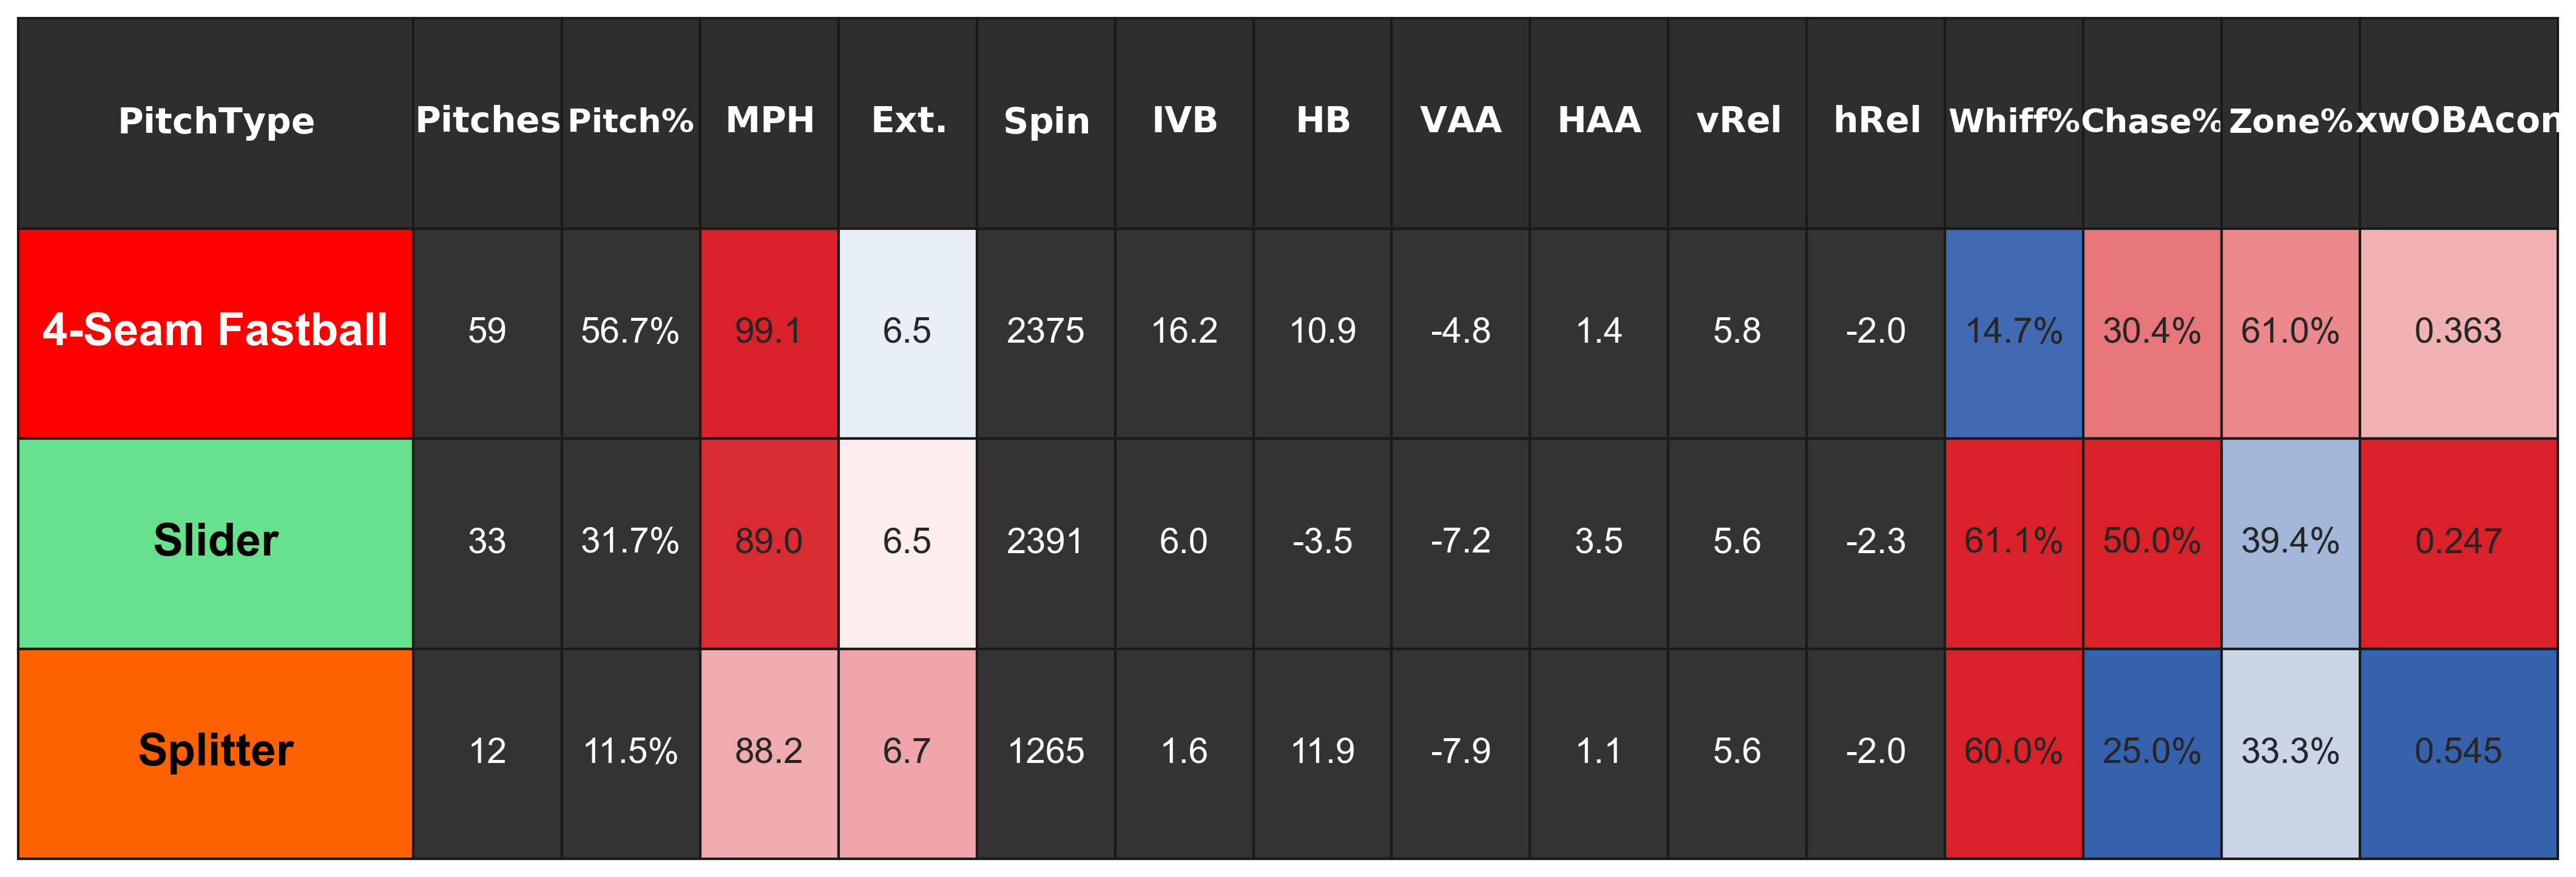

In [116]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import matplotlib

matplotlib.rcParams.update({'font.size': 22})

def plot_pitch_stats_table(df, ax, pitcher_id, stats, pitching_dict, league_averages):
    ax.set_facecolor('#2e2e2e')
    ax.tick_params(axis='both', colors='white')  

    pitcher_data = df[df['pitcher_id'] == pitcher_id]

    if pitcher_data.empty:
        print(f"Warning: No data found for pitcher ID {pitcher_id}")
        ax.text(0.5, 0.5, "No Data Available", ha='center', va='center', fontsize=20, color='white')
        ax.axis('off')
        return

    summary_data = pitcher_data.groupby('pitch_type')[stats].agg({
        'is_pitch': 'sum', 
        'start_speed': 'mean',  
        'ivb': 'mean',  
        'hb': 'mean',  
        'x0': 'mean',  
        'z0': 'mean',  
        'extension': 'mean',  
        'is_swing': 'sum', 
        'is_whiff': 'sum',  
        'is_strike': 'sum', 
        'spin_rate': 'mean',
        'VAA': 'mean',
        'HAA': 'mean',
        'xwOBAcon': 'mean',  
    }).reset_index()
    
    total_pitches = pitcher_data['is_pitch'].sum()
    summary_data['Pitch%'] = (summary_data['is_pitch'] / total_pitches) * 100  
    
    summary_data['Whiff%'] = summary_data.apply(
        lambda row: f'--' if row['is_swing'] == 0 else f'{(row["is_whiff"] / row["is_swing"]) * 100:.1f}%', axis=1
    )

    # summary_data['Chase%'] = summary_data.apply(
    #     lambda row: '--' if pitcher_data[(pitcher_data["zone"] > 10) & 
    #                                     (pitcher_data["pitch_type"] == row["pitch_type"])].shape[0] == 0 
    #     else f'{(
    #         pitcher_data[(pitcher_data["zone"] > 10) & 
    #                     (pitcher_data["is_swing"] == 1) & 
    #                     (pitcher_data["pitch_type"] == row["pitch_type"])].shape[0] / 
    #         pitcher_data[(pitcher_data["zone"] > 10) & 
    #                     (pitcher_data["pitch_type"] == row["pitch_type"])].shape[0]
    #     ) * 100:.1f}%', 
    #     axis=1
    # )
    def calc_chase(row):
        pt = row['pitch_type']
        out_zone = pitcher_data[(pitcher_data['zone'] > 10) & (pitcher_data['pitch_type'] == pt)]
        if out_zone.empty:
            return '--'
        swings = out_zone[out_zone['is_swing'] == 1].shape[0]
        return f'{(swings / out_zone.shape[0]) * 100:.1f}%'

    summary_data['Chase%'] = summary_data.apply(calc_chase, axis=1)


    summary_data['wOBAcon'] = summary_data['xwOBAcon'].fillna('--')
    summary_data['Zone%'] = summary_data['pitch_type'].map(lambda x: (pitcher_data[pitcher_data['zone'] <= 9].groupby('pitch_type')['is_pitch'].sum().get(x, 0) / summary_data.loc[summary_data['pitch_type'] == x, 'is_pitch'].values[0]) * 100)

    summary_data = summary_data.sort_values(by='is_pitch', ascending=False)

    for col in stats:
        if col != 'pitch_type':  
            summary_data[col] = summary_data[col].apply(lambda x: format(x, pitching_dict.get(col, {}).get('format', '')))

    summary_data['Pitch%'] = summary_data['Pitch%'].apply(lambda x: f'{x:.1f}%')
    summary_data['Whiff%'] = summary_data['Whiff%'].apply(lambda x: f'{x:.1f}%' if isinstance(x, (int, float)) else x)
    summary_data['Zone%'] = summary_data['Zone%'].apply(lambda x: f'{x:.1f}%' if isinstance(x, (int, float)) else x) 
    summary_data['Chase%'] = summary_data['Chase%'].apply(lambda x: f'{x:.1f}%' if isinstance(x, (int, float)) else x)  

    summary_data = summary_data[['pitch_type', 'is_pitch', 'Pitch%', 'start_speed', 'extension', 'spin_rate','ivb', 'hb','VAA','HAA', 'z0', 'x0', 'Whiff%', 'Chase%','Zone%', 'xwOBAcon']]

    new_column_names = [
    pitching_dict.get(col, {}).get('table_header', col) for col in summary_data.columns
    ]

    table_pb = ax.table(cellText=summary_data.values, colLabels=new_column_names, cellLoc='center', bbox=[0.00, 0.0, 1, 1])
    table_pb.auto_set_font_size(False)
    table_pb.set_fontsize(14)
    

    column_widths = [0.2, 0.075, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07,0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.1,0.1] 

    for i, col in enumerate(summary_data.columns):
        for j in range(len(summary_data)):
            table_pb.get_celld()[(j + 1, i)].set_width(column_widths[i])
    for i in range(len(summary_data.columns)):
        table_pb.get_celld()[(0, i)].set_width(column_widths[i])  # Header row columns

    for col_idx, col_name in enumerate(summary_data.columns):
        if col_name in ['is_pitch', 'Pitch%', 'spin_rate', 'ivb', 'hb', 'z0', 'x0','VAA','HAA']: 
            for row_idx in range(1, len(summary_data) + 1): 
                cell = table_pb[(row_idx, col_idx)] 
                cell.set_facecolor('#333333') 
                cell.set_text_props(color='white')  
            if col_name in ['is_pitch', 'Pitch%', 'spin_rate', 'ivb', 'hb', 'z0', 'x0','VAA','HAA']:
                cell.set_facecolor('#333333')
                cell.set_text_props(color='white')
            else:
                cell.set_facecolor('#f2f2f2')
                cell.set_text_props(color='black')  

    
    new_column_names = [pitching_dict.get(x, {}).get('table_header', x) for x in summary_data.columns]
    for i, col_name in enumerate(new_column_names):
        table_pb[(0, i)].set_text_props(fontweight='bold') 
        
    cmap_r = mcolors.LinearSegmentedColormap.from_list('grad_red_blue', ['#D82129', '#FFFFFF', '#3661AD']) 
    cmap = mcolors.LinearSegmentedColormap.from_list('grad_red_blue', ['#3661AD', '#FFFFFF', '#D82129'])  
    
    for i, pitch_type in enumerate(summary_data['pitch_type']):
        for j, col in enumerate(['start_speed', 'extension', 'Whiff%', 'Zone%', 'Chase%', 'xwOBAcon']):
            value = summary_data.iloc[i][col]

            if pd.isna(value) or value == '' or value is None:
                value = '--'  # Replace NaN or empty value with '--'

            elif isinstance(value, str):
                if value == '--':  # Skip '--' entries
                    continue
                if value == 'nan':  # Skip if the value is the string 'nan'
                    value = '--'  # Treat 'nan' string as missing
                else:
                    value = float(value.replace('%', '')) 

            try:
                league_avg = float(league_averages[pitch_type].get(col, None)) 
                if league_avg is None:
                    continue
            except ValueError:
                continue

            norm = None

            if col == 'start_speed':
                norm = mcolors.Normalize(vmin=league_avg - 4, vmax=league_avg + 4) 
            elif col == 'extension':
                norm = mcolors.Normalize(vmin=league_avg - .5, vmax=league_avg + .6) 
            elif col == 'Whiff%':
                norm = mcolors.Normalize(vmin=league_avg - 8, vmax=league_avg + 8) 
            elif col == 'Zone%':
                norm = mcolors.Normalize(vmin=league_avg - 12, vmax=league_avg + 12)  
            elif col == 'Chase%':
                norm = mcolors.Normalize(vmin=league_avg - 10, vmax=league_avg + 10)  
            elif col == 'xwOBAcon':  
                norm = mcolors.Normalize(vmin=league_avg - .1, vmax=league_avg + .1)  

            # Apply the colormap only if the value is not '--'
            if value != '--':
                color = cmap(norm(value))  # Apply colormap based on normalized value
            else:
                color = (1, 1, 1)  # Set a neutral color (white) for '--' values
            
            if col == 'start_speed':
                cell = table_pb[(i + 1, 3)] 
            elif col == 'extension':
                cell = table_pb[(i + 1, 4)] 
            elif col == 'Whiff%':
                cell = table_pb[(i + 1, 12)] 
            elif col == 'Chase%':
                cell = table_pb[(i + 1, 13)]  
            elif col == 'Zone%':
                cell = table_pb[(i + 1, 14)]  
            elif col == 'xwOBAcon':
               
                color_r = cmap_r(norm(value)) if value != '--' else (1, 1, 1) 
                cell = table_pb[(i + 1, 15)] 
                cell.set_facecolor(mcolors.to_hex(color_r)) 
            
            if col != 'xwOBAcon': 
                cell.set_facecolor(mcolors.to_hex(color))
            # If the value is '--', set the cell text to '--'
            if value == '--':
                cell.get_text().set_text('--') 

        pitch_color = pitch_colours.get(pitch_type, {}).get('colour', '#FFFFFF') 
        pitch_name = pitch_colours.get(pitch_type, {}).get('name', 'NA')
        cell = table_pb[(i + 1, 0)] 
        cell.set_facecolor(pitch_color) 
        cell_text = cell.get_text()
        cell_text.set_text(pitch_name) 
        cell_text.set_fontweight('bold') 
        cell_text.set_fontsize(18)  

        if pitch_type in ['CH', 'FS', 'SC', 'FO','SL']:
            cell_text.set_color('black') 
        else:
            cell_text.set_color('white') 
        cell_text.set_fontweight('bold') 
     
    for i, col_name in enumerate(new_column_names):
        cell = table_pb.get_celld()[(1, i)]
        cell = table_pb[(0, i)]  
        cell_text = cell.get_text()
        cell.get_text().set_text(col_name)
        cell_text.set_fontweight('bold')
        cell.set_facecolor('#2e2e2e')  
        cell_text.set_color('white')  
        if col_name in ['Pitch%', 'Whiff%', 'Zone%', 'Chase%']:  
            cell.get_text().set_fontproperties("DejaVu Sans") 
            cell.get_text().set_fontweight('bold') 
            cell.get_text().set_fontsize(13)
        
    ax.axis('off')

pitcher_id = pitcher_id 
stats = ['pitch_type', 'is_pitch', 'start_speed', 'spin_rate', 'ivb', 'hb', 'x0', 'z0', 'extension', 'is_swing', 'is_whiff', 'is_strike', 'VAA','HAA','xwOBAcon']

fig, ax = plt.subplots(figsize=(18, 6)) 
plot_pitch_stats_table(df, ax=ax, pitcher_id=pitcher_id, stats=stats, pitching_dict=pitching_dict, league_averages=league_averages)
plt.show()

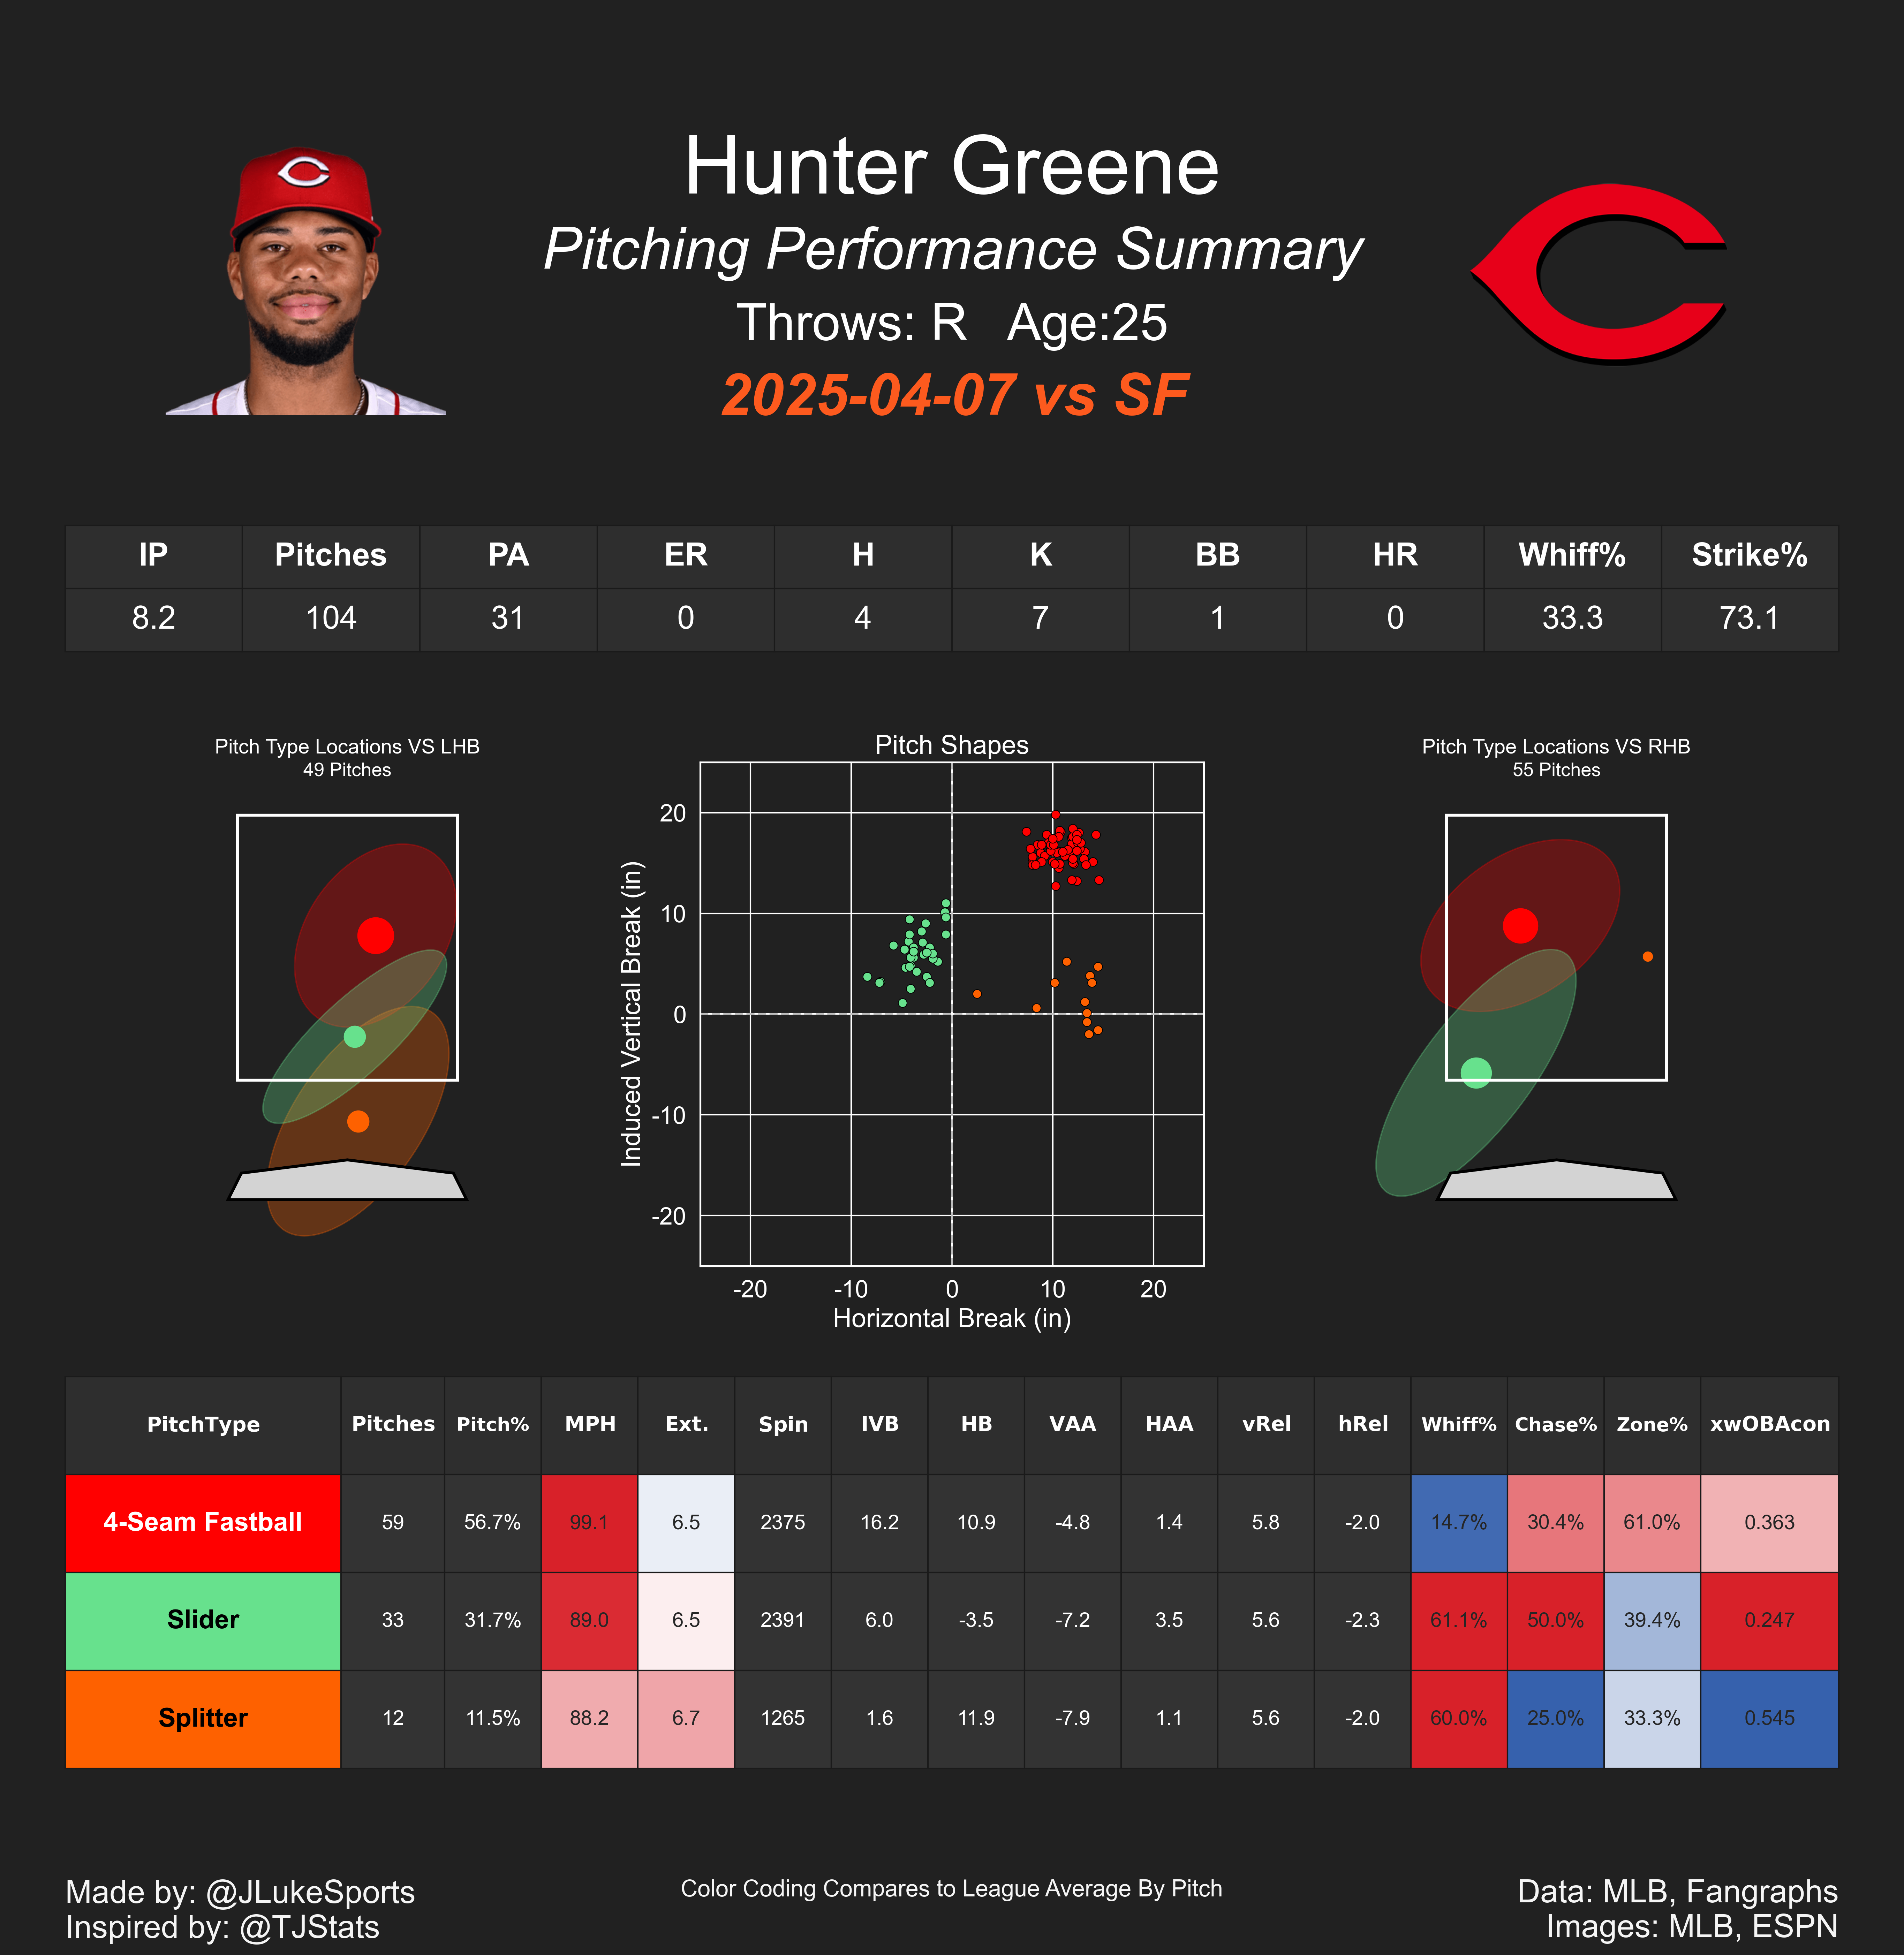

In [109]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

def pitching_proj_dashboard(pitcher_id: str, df: pd.DataFrame, df_table: pd.DataFrame, stats: list):
    dark_bg = '#212121'  
    light_text = '#F5F5F5'
    accent_color = '#FF5722'
    dark_gray = '#616161'
    fig = plt.figure(figsize=(20, 20), facecolor=dark_bg)
    gs = gridspec.GridSpec(6, 8, width_ratios=[1, 18, 18, 18, 18, 18, 18, 1],
                                height_ratios=[1, 20, 9, 36, 28, 1])
    
    ax_header = fig.add_subplot(gs[0, 1:7], facecolor=dark_bg) 
    ax_footer = fig.add_subplot(gs[-1, 1:7], facecolor=dark_bg)
    ax_left = fig.add_subplot(gs[:, 0], facecolor=dark_bg)
    ax_right = fig.add_subplot(gs[:, -1], facecolor=dark_bg)
    
    ax_footer.axis('off')
    ax_header.axis('off')
    ax_left.axis('off')
    ax_right.axis('off')

    headshot_ax = fig.add_subplot(gs[1, 1:3], facecolor=dark_bg)
    bio_ax = fig.add_subplot(gs[1, 3:5], facecolor=dark_bg) 
    logo_ax = fig.add_subplot(gs[1, 5:7], facecolor=dark_bg)
    pitch_plot_ax = plt.subplot(gs[3, 3:5], facecolor=dark_bg)
    lhb_plot_ax = plt.subplot(gs[3, 1:3], facecolor=dark_bg) 
    rhb_plot_ax = plt.subplot(gs[3, 5:7], facecolor=dark_bg)
    stats_table_ax = plt.subplot(gs[4, 1:7], facecolor=dark_bg) 
    summary_table_ax = plt.subplot(gs[2, 1:7], facecolor=dark_bg) 

    player_headshot(pitcher_id=pitcher_id, ax=headshot_ax)
    player_bio(pitcher_id=pitcher_id, ax=bio_ax)
    plot_logo(pitcher_id=pitcher_id, ax=logo_ax)

    break_plot(df=df, pitcher_id=pitcher_id, ax=pitch_plot_ax)
    plot_lhb_pitch_locations(df=df, pitcher_id=pitcher_id, ax=lhb_plot_ax)
    plot_rhb_pitch_locations(df=df, pitcher_id=pitcher_id, ax=rhb_plot_ax)
    plot_pitch_stats_table(df, ax=stats_table_ax, pitcher_id=pitcher_id, stats=stats, pitching_dict=pitching_dict, league_averages=league_averages)
    pitching_table(df=df, df_table=df_table, ax=summary_table_ax)

    ax_footer.text(0, 1, 'Made by: @JLukeSports \nInspired by: @TJStats', ha='left', va='top', fontsize=22, color=light_text)
    ax_footer.text(0.5, 1, 'Color Coding Compares to League Average By Pitch', ha='center', va='top', fontsize=16, color=light_text)
    ax_footer.text(1, 1, 'Data: MLB, Fangraphs\nImages: MLB, ESPN', ha='right', va='top', fontsize=22, color=light_text)

    plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.5)


    plt.show()

pitcher_id = pitcher_id 
stats = ['pitch_type', 'is_pitch', 'start_speed', 'spin_rate', 'ivb', 'hb', 'x0', 'z0', 'extension', 'is_swing', 'is_whiff', 'is_strike','VAA','HAA','xwOBAcon']

pitching_proj_dashboard(pitcher_id, df, df_table, stats)
